# Load data

In [3]:
import numpy as np
from scipy import stats
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
import anndata as ad
import mygene

In [60]:
#adata = ad.read_h5ad("/storage/users/data/PANC/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust_time_pub.h5ad")
#adata = ad.read_h5ad("/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust_time_pub.h5ad")
#adata = sc.read('/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust_time4_clust.h5ad')
#adata = sc.read("/scratch/users/data/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust_time4.h5ad")
#adata = sc.read('/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust_palantir.h5ad')
adata = sc.read("/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust.h5ad")

In [61]:
bdata = adata.copy()
bdata.var_names = bdata.var['gene_symbol']

/home/job37yv/miniforge3/envs/scAnalysis/lib/python3.10/site-packages/anndata/_core/anndata.py:845: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ISG15', '', 'C1QTNF12', 'CFAP74', '']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [62]:
adata

AnnData object with n_obs × n_vars = 6235 × 1992
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'CMO', 'gene_symbol', 'mito', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Create dictionary ensembl2symbol

In [63]:
import mygene

# Extract Ensembl Gene IDs from combined_adata
ensembl_ids = adata.var_names.tolist()

# Initialize MyGene.info client
mg = mygene.MyGeneInfo()

# Query MyGene.info for mappings
print("Querying MyGene.info...")
results = mg.querymany(
    ensembl_ids,
    scopes="ensembl.gene",
    fields="symbol",
    species="human"
)

# Initialize an empty dictionary to store the mapping
ensembl_to_gene_name = {}

# Populate the dictionary
print("Processing results...")
for res in results:
    ensembl_id = res.get("query")
    if "notfound" in res:
        # Skip if not found
        continue
    # Use the symbol field as the gene name
    ensembl_to_gene_name[ensembl_id] = res.get("symbol", ensembl_id)

# Display the resulting dictionary
print("\nEnsembl to Gene Name mapping:")
#print(ensembl_to_gene_name)


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Querying MyGene.info...


3 input query terms found dup hits:	[('ENSG00000227110', 2), ('ENSG00000226519', 2), ('ENSG00000262352', 3)]
34 input query terms found no hit:	['ENSG00000286863', 'ENSG00000275557', 'ENSG00000231877', 'ENSG00000233005', 'ENSG00000237838', 'ENS


Processing results...

Ensembl to Gene Name mapping:


In [64]:
adata.var["ensembl_gene_id"] = adata.var_names.astype(str)

In [65]:
adata.var["gene_symbol"] = adata.var_names.map(ensembl_to_gene_name)

In [66]:
adata.var["gene_symbol"] = adata.var["gene_symbol"].fillna(adata.var["ensembl_gene_id"])

print("Remaining NaN in 'gene_symbol':", adata.var["gene_symbol"].isna().sum())


Remaining NaN in 'gene_symbol': 0


In [67]:
adata.var_names = adata.var['gene_symbol']

# Differential Analysis Specific

## Analysis

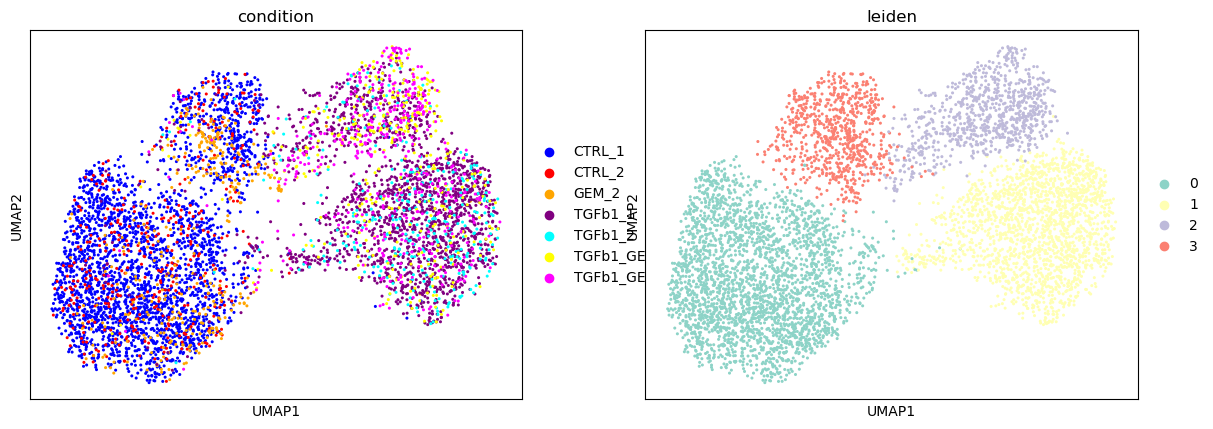

In [68]:
sc.pl.umap(adata, color=[ "condition","leiden"])

In [69]:
group1 = '1_leiden-3'
group2 = '2_leiden-0'
comparison = group1 + "_vs_" + group2
group1_cluster = ["3"]
group2_cluster = ["0"]

In [72]:
# Define a function to label clusters:
def label_clusters(cluster):
    if cluster in group1_cluster:
        return group1
    elif cluster in group2_cluster:
        return group2
    else:
        return "NA"  # This label will be used to filter out other clusters

# Create a new categorical column for comparison
adata.obs['compare_clusters'] = adata.obs['leiden'].map(label_clusters)

In [74]:
unique_categories = adata.obs['compare_clusters'].unique()
print(unique_categories)

['2_leiden-0' '1_leiden-3' 'NA']


In [104]:
# Subset adata to exclude 'NA'
adata_sub = adata[adata.obs['compare_clusters'] != 'NA']  # or .isin([group1, group2])

# Run differential expression on just these two groups
sc.tl.rank_genes_groups(
    adata_sub, 
    groupby='compare_clusters', 
    groups=[group1, group2]   # or [group1] and specify reference below
)

# Now retrieve the genes of interest from adata_sub
de_genes = adata_sub.uns['rank_genes_groups']['names'][group1]
print(de_genes[:20])

# Get differentially expressed genes for the comparison
de_genes = adata_sub.uns['rank_genes_groups']['names'][group2]
print(de_genes[0:20])


['TPX2' 'CENPF' 'H2AZ1' 'BIRC5' 'TOP2A' 'TUBA1B' 'HMGB2' 'SMC4' 'PCLAF'
 'UBE2S' 'PRC1' 'PTTG1' 'CEP55' 'MKI67' 'CENPW' 'NUSAP1' 'HMGB1' 'CKS2'
 'ARL6IP1' 'ANLN']
['H2AC6' 'RPS18' 'FTL' 'ZFAS1' 'CD55' 'AFAP1' 'NR2F1' 'AKAP12' 'ANGPTL4'
 'SLC5A3' 'NEAT1' 'ZBTB20' 'STXBP5' 'SAT1' 'KCNK15' 'KRT8' 'FAM89B' 'FTH1'
 'INHBA' 'CITED4']


/home/job37yv/miniforge3/envs/scAnalysis/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:639: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [105]:
# Convert result to dataframe
result = pd.DataFrame({
    'symbol': adata_sub.uns['rank_genes_groups']['names'][group1],
    'log2FC': adata_sub.uns['rank_genes_groups']['logfoldchanges'][group1],
    'p.value': adata_sub.uns['rank_genes_groups']['pvals'][group1],
    'adjusted.p.value': adata_sub.uns['rank_genes_groups']['pvals_adj'][group1]
})

# Calculate basemean expression for genes present in adata.var_names
result['basemean'] = [
    (adata_sub[:, gene].X.sum() / adata_sub.shape[0]) if gene in adata_sub.var_names else 'NA' 
    for gene in result['symbol']
]

# Convert ensembl IDs to gene symbols
#result['symbol'] = result['ID'].map(ensembl_to_gene_name).fillna(result['ID'])
# Reverse the dictionary to map gene symbols to Ensembl IDs
gene_name_to_ensembl = {v: k for k, v in ensembl_to_gene_name.items() if v}
result['ensembl_id'] = result['symbol'].map(gene_name_to_ensembl).fillna(result['symbol'])

# Assign comparison name
result['comparison'] = group1 + "_vs_" + group2

# Sort by absolute log2FC
result = result.reindex(result['adjusted.p.value'].abs().sort_values(ascending=True).index)

In [106]:
result.head(50)

,symbol,log2FC,p.value,adjusted.p.value,basemean,ensembl_id,comparison
0,TPX2,5.470545,0.000000e+00,0.000000e+00,0.553461,ENSG00000088325,1_leiden-3_vs_2_leiden-0
1,CENPF,5.412909,0.000000e+00,0.000000e+00,0.589768,ENSG00000117724,1_leiden-3_vs_2_leiden-0
6,HMGB2,3.295053,0.000000e+00,0.000000e+00,0.782624,ENSG00000164104,1_leiden-3_vs_2_leiden-0
5,TUBA1B,2.701205,0.000000e+00,0.000000e+00,1.520660,ENSG00000123416,1_leiden-3_vs_2_leiden-0
2,H2AZ1,2.676273,0.000000e+00,0.000000e+00,1.500092,ENSG00000164032,1_leiden-3_vs_2_leiden-0
3,BIRC5,5.241786,5.507925e-312,1.828631e-309,0.434111,ENSG00000089685,1_leiden-3_vs_2_leiden-0
9,UBE2S,2.879616,9.901056e-312,2.817558e-309,1.185166,ENSG00000108106,1_leiden-3_vs_2_leiden-0
8,PCLAF,3.566221,9.237326e-310,2.300094e-307,0.685514,ENSG00000166803,1_leiden-3_vs_2_leiden-0
4,TOP2A,6.238315,5.339644e-300,1.181841e-297,0.546673,ENSG00000131747,1_leiden-3_vs_2_leiden-0
7,SMC4,3.944340,1.303132e-296,2.595839e-294,0.492039,ENSG00000113810,1_leiden-3_vs_2_leiden-0


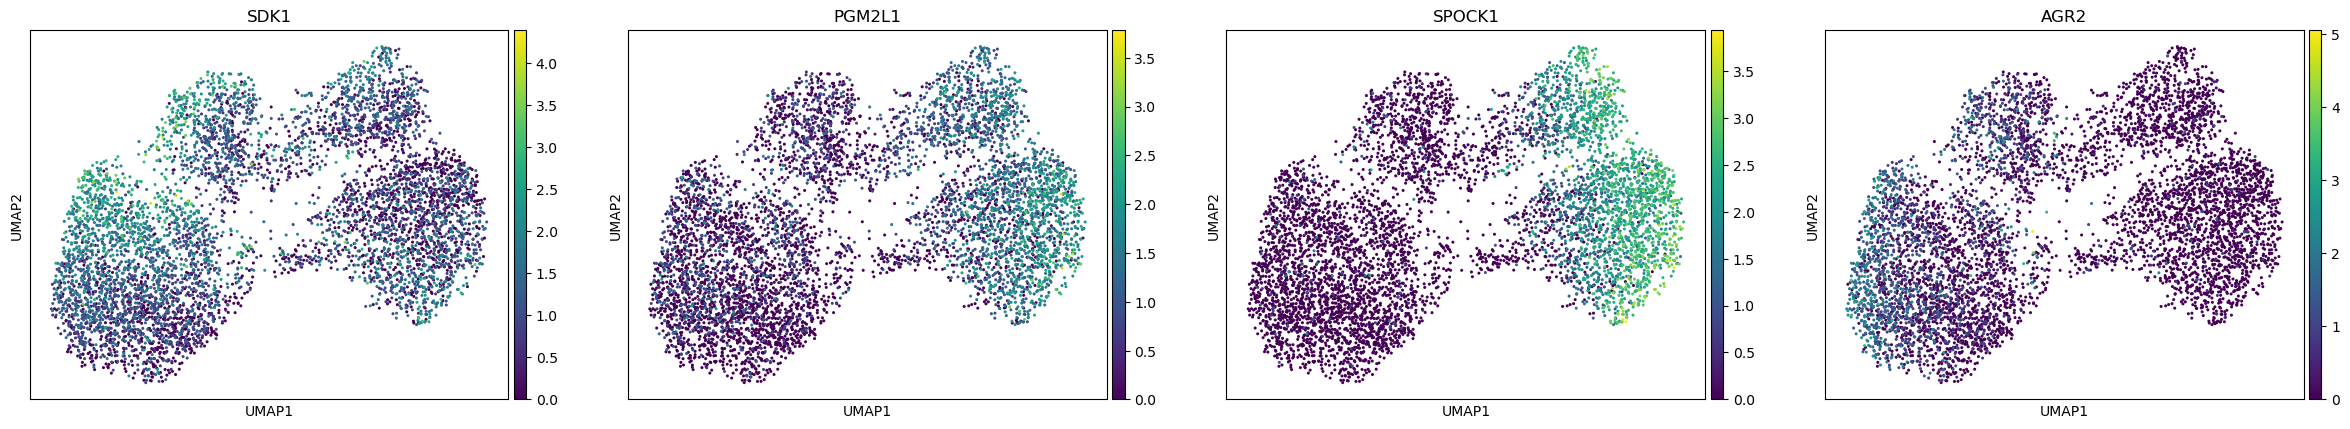

In [107]:
sc.pl.umap(adata, color=["SDK1", 'PGM2L1','SPOCK1','AGR2'])

In [108]:
#Specify the path for the output text file
output_file = '../../data/deg_' + comparison + '.txt'

result.to_csv(output_file, sep='\t', index=False)

print(f"Differentially expressed genes saved to {output_file}")

Differentially expressed genes saved to ../../data/deg_1_leiden-3_vs_2_leiden-0.txt


## Barplot

/tmp/ipykernel_2149104/4099969013.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_by_pvalue['log2FC'] = top_by_pvalue['log2FC'].astype(float)
/tmp/ipykernel_2149104/4099969013.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_by_pvalue['basemean'] = top_by_pvalue['basemean'].astype(float)
/tmp/ipykernel_2149104/4099969013.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for 

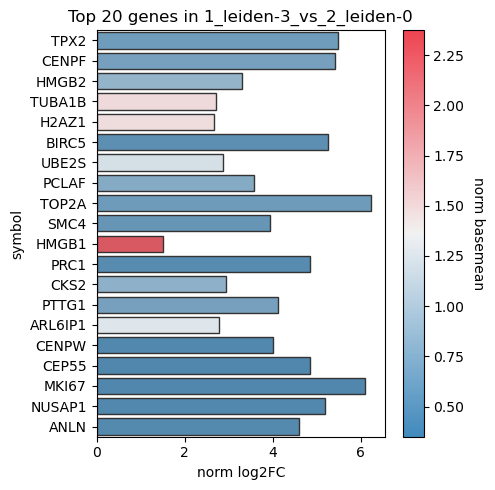

In [109]:
filtered_results = result
comparison = group1 + "_vs_" + group2


# Initialize the 4x2 subplot grid
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.subplots_adjust(hspace=0.5)  # Adjust space between plots


# Get top 20 genes by adjusted.p.value
n_top_genes = 20  # for instance
#top_by_pvalue = filtered_results.sort_values(by="adjusted.p.value", ascending=True).head(n_top_genes)
top_by_pvalue = filtered_results.head(n_top_genes)

# Now, sort those top 20 genes by symbol
top_genes = top_by_pvalue.sort_values(by="symbol", ascending=True)

# Make sure 'log2FC' and 'basemean' are numeric (float)
top_by_pvalue['log2FC'] = top_by_pvalue['log2FC'].astype(float)
top_by_pvalue['basemean'] = top_by_pvalue['basemean'].astype(float)


norm_log2FC = plt.Normalize(top_by_pvalue["log2FC"].min(), top_by_pvalue["log2FC"].max())
norm_basemean = plt.Normalize(top_by_pvalue["basemean"].min(), top_by_pvalue["basemean"].max())

# Generate a color mapping for log2FC
cmap = sns.diverging_palette(240, 10, s=80, l=55, as_cmap=True)  # Blue to white to red

# Use norm_* functions directly on Series.values, ensuring they're in a compatible format
log2FC_colors = cmap(norm_log2FC(top_by_pvalue["log2FC"].values))
basemean_colors = cmap(norm_basemean(top_by_pvalue["basemean"].values))


# Generate a bar plot in the appropriate subplot
#ax = axes[index // 2, index % 2]  # Determine the row and column for subplot

sns.barplot(data=top_by_pvalue, x="log2FC", y="symbol", palette=basemean_colors, edgecolor=".2", ax=ax)
ax.set_title(f"Top {n_top_genes} genes in {comparison}")
ax.set_xlabel('norm log2FC')  # Set x-axis label
ax.set_ylabel('symbol')  # Clear y-axis label for brevity

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_basemean)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("norm basemean", rotation=270, labelpad=15)


plt.tight_layout()
plt.savefig("../../figures/barplot_" + comparison + ".png")
plt.show()


## Volcano

/home/job37yv/miniforge3/envs/scAnalysis/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


     symbol    log2FC        p.value  adjusted.p.value  basemean  \
3     BIRC5  5.241786  5.507925e-312     1.828631e-309  0.434111   
9     UBE2S  2.879616  9.901056e-312     2.817558e-309  1.185166   
8     PCLAF  3.566221  9.237326e-310     2.300094e-307  0.685514   
4     TOP2A  6.238315  5.339644e-300     1.181841e-297  0.546673   
7      SMC4  3.944340  1.303132e-296     2.595839e-294  0.492039   
16    HMGB1  1.498024  8.366158e-294     1.515035e-291  2.373781   
10     PRC1  4.844029  1.119497e-269     1.858365e-267  0.390895   
17     CKS2  2.937510  2.210899e-268     3.387778e-266  0.741505   
11    PTTG1  4.129400  8.017382e-267     1.140759e-264  0.594291   
18  ARL6IP1  2.780185  1.072608e-255     1.424423e-253  1.249737   
14    CENPW  3.994933  9.032762e-255     1.124579e-252  0.362575   
12    CEP55  4.854973  5.031748e-250     5.896024e-248  0.354984   
13    MKI67  6.090958  1.043413e-241     1.154710e-239  0.349918   
15   NUSAP1  5.184560  5.376931e-241     5.63728

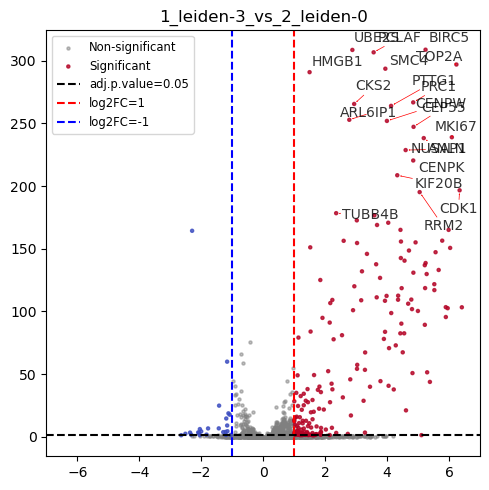

In [110]:
## Take care: zero pvalue cannot be displayed

filtered_results = result
comparison = group1 + "_vs_" + group2

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

log2fc_threshold = 1
adj_pval_threshold = 0.05

# Define a mask for significant genes
significant_mask = (filtered_results['log2FC'].abs() > log2fc_threshold) & (filtered_results['log2FC'] != 0) & (filtered_results['adjusted.p.value'] < adj_pval_threshold) & (filtered_results['adjusted.p.value'] != 0)

# Scatter points: Non-significant
ax.scatter(filtered_results.loc[~significant_mask, 'log2FC'], -np.log10(filtered_results.loc[~significant_mask, 'adjusted.p.value']),
           color='grey', alpha=0.5, s=5, label='Non-significant')

# Scatter points: Significant
ax.scatter(filtered_results.loc[significant_mask, 'log2FC'], -np.log10(filtered_results.loc[significant_mask, 'adjusted.p.value']),
           c=np.sign(filtered_results.loc[significant_mask, 'log2FC']), cmap="coolwarm", alpha=0.8, s=5, label='Significant')

# Horizontal line for adjusted p-value significance threshold
ax.axhline(y=-np.log10(adj_pval_threshold), color='black', linestyle='--', label=f'adj.p.value={adj_pval_threshold}')

# Vertical lines for log2FC significance threshold
ax.axvline(x=log2fc_threshold, color='red', linestyle='--', label=f'log2FC={log2fc_threshold}')
ax.axvline(x=-log2fc_threshold, color='blue', linestyle='--', label=f'log2FC=-{log2fc_threshold}')

ax.set_title(comparison)
ax.set_xlim(-7, 7)
#ax.set_ylim(-7, 400)
ax.legend(loc='upper left', fontsize='small')

# Annotate significant genes
#significant_genes = filtered_results[significant_mask]
#significant_genes = filtered_results[significant_mask].sort_values(by="adjusted.p.value", ascending=True)
significant_genes = filtered_results[significant_mask].sort_values(by="adjusted.p.value", ascending=True).head(20)


#.nsmallest(20, 'adjusted.p.value')
print(significant_genes)

texts = []
epsilon = 0 * 1e-20  # a small constant
for _, row in significant_genes.iterrows():
    adj_pval = row['adjusted.p.value'] + epsilon
    y_val = -np.log10(adj_pval)
    if np.isfinite(y_val):
        texts.append(ax.text(row['log2FC'], y_val, row['symbol'], fontsize=10, alpha=0.8))

adjust_text(texts, ax=ax, only_move={'points': 'y', 'text': 'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))


plt.tight_layout()
plt.savefig("../../figures/volcano_" + comparison + ".png")
plt.show()

# Differential Analysis Systematic

In [111]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [112]:
adata

AnnData object with n_obs × n_vars = 6235 × 1992
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier', 'leiden', 'compare_clusters'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'CMO', 'gene_symbol', 'mito', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_gene_id'
    uns: 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [113]:
adata.obs["condition"]

barcode
AAACCCAGTAGGCTCC-1         CTRL_1
AAACCCAGTCGCAACC-1         CTRL_1
AAACCCATCCACAAGT-1         CTRL_1
AAACGCTTCACTACGA-1         CTRL_1
AAAGAACAGATACAGT-1         CTRL_1
                         ...     
TTTACTGTCATTACTC-1    TGFb1_GEM_2
TTTCACAGTGATATAG-1    TGFb1_GEM_2
TTTCACATCGATGCAT-1    TGFb1_GEM_2
TTTCATGTCCCTCTAG-1    TGFb1_GEM_2
TTTGACTGTTCCGGTG-1    TGFb1_GEM_2
Name: condition, Length: 6235, dtype: category
Categories (7, object): ['CTRL_1', 'CTRL_2', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']

In [114]:
adata.obs["leiden"]

barcode
AAACCCAGTAGGCTCC-1    0
AAACCCAGTCGCAACC-1    0
AAACCCATCCACAAGT-1    0
AAACGCTTCACTACGA-1    0
AAAGAACAGATACAGT-1    0
                     ..
TTTACTGTCATTACTC-1    0
TTTCACAGTGATATAG-1    2
TTTCACATCGATGCAT-1    2
TTTCATGTCCCTCTAG-1    1
TTTGACTGTTCCGGTG-1    2
Name: leiden, Length: 6235, dtype: category
Categories (4, object): ['0', '1', '2', '3']

### Define new obs/category of cells

#### GEM subset of leiden

In [115]:
# Number of cells in Leiden 3
count_leiden3 = (adata.obs['leiden'] == '3').sum()
print(f"Total cells in Leiden 3: {count_leiden3}")

# Number of cells in Leiden 3 AND condition == GEM_2
count_leiden3_gem2 = ((adata.obs['leiden'] == '3') & (adata.obs['condition'] == 'GEM_2')).sum()
print(f"Cells in Leiden 3 and GEM_2: {count_leiden3_gem2}")

# Number of cells in Leiden 0
count_leiden0 = (adata.obs['leiden'] == '0').sum()
print(f"Total cells in Leiden 0: {count_leiden0}")

# Number of cells in Leiden 0 AND condition == GEM_2
count_leiden0_gem2 = ((adata.obs['leiden'] == '0') & (adata.obs['condition'] == 'GEM_2')).sum()
print(f"Cells in Leiden 0 and GEM_2: {count_leiden0_gem2}")

# Number of cells in Leiden 2
count_leiden2 = (adata.obs['leiden'] == '2').sum()
print(f"Total cells in Leiden 2: {count_leiden2}")

# Number of cells in Leiden 2 AND condition in [TGFb1_GEM_1, TGFb1_GEM_2]
count_leiden2_tgfb1_gem = ((adata.obs['leiden'] == '2') & 
                           (adata.obs['condition'].isin(['TGFb1_GEM_1', 'TGFb1_GEM_2']))).sum()
print(f"Cells in Leiden 2 and TGFb1_GEM_1/GEM_2: {count_leiden2_tgfb1_gem}")

# Number of cells in Leiden 1 AND condition in [TGFb1_GEM_1, TGFb1_GEM_2]
count_leiden1 = (adata.obs['leiden'] == '1').sum()
count_leiden1_tgfb1_gem = ((adata.obs['leiden'] == '1') & 
                           (adata.obs['condition'].isin(['TGFb1_GEM_1', 'TGFb1_GEM_2']))).sum()
print(f"Total cells in Leiden 1: {count_leiden1}")
print(f"Cells in Leiden 1 and TGFb1_GEM_1/GEM_2: {count_leiden1_tgfb1_gem}")


Total cells in Leiden 3: 752
Cells in Leiden 3 and GEM_2: 132
Total cells in Leiden 0: 2761
Cells in Leiden 0 and GEM_2: 185
Total cells in Leiden 2: 855
Cells in Leiden 2 and TGFb1_GEM_1/GEM_2: 397
Total cells in Leiden 1: 1867
Cells in Leiden 1 and TGFb1_GEM_1/GEM_2: 328


In [118]:
def label_leiden_gem(row):
    # row['leiden'] and row['condition'] are strings
    if row['leiden'] == '3' and row['condition'] == 'GEM_2':
        return 'Leiden3_GEM2'
    elif row['leiden'] == '0' and row['condition'] == 'GEM_2':
        return 'Leiden0_GEM2'
    elif row['leiden'] == '2' and row['condition'] in ['TGFb1_GEM_1', 'TGFb1_GEM_2']:
        return 'Leiden2_TGFb1_GEM'
    elif row['leiden'] == '1' and row['condition'] in ['TGFb1_GEM_1', 'TGFb1_GEM_2']:
        return 'Leiden1_TGFb1_GEM'
    else:
        return 'other'

adata.obs['leiden_gem'] = adata.obs.apply(label_leiden_gem, axis=1)

# Check resulting categories:
print(adata.obs['leiden_gem'].value_counts())

leiden_gem
other                5193
Leiden2_TGFb1_GEM     397
Leiden1_TGFb1_GEM     328
Leiden0_GEM2          185
Leiden3_GEM2          132
Name: count, dtype: int64


#### GEM and not-GEM subset of leiden

In [198]:
def label_leiden_gem_extended(row):
    # For Leiden 3
    if row['leiden'] == '3':
        if row['condition'] == 'GEM_2':
            return 'Leiden3_GEM2'
        else:
            return 'Leiden3_nonGEM2'
    # For Leiden 0
    elif row['leiden'] == '0':
        if row['condition'] == 'GEM_2':
            return 'Leiden0_GEM2'
        else:
            return 'Leiden0_nonGEM2'
    # For Leiden 2
    elif row['leiden'] == '2':
        if row['condition'] in ['TGFb1_GEM_1', 'TGFb1_GEM_2']:
            return 'Leiden2_TGFb1_GEM'
        else:
            return 'Leiden2_nonTGFb1_GEM'
    # For Leiden 1
    elif row['leiden'] == '1':
        if row['condition'] in ['TGFb1_GEM_1', 'TGFb1_GEM_2']:
            return 'Leiden1_TGFb1_GEM'
        else:
            return 'Leiden1_nonTGFb1_GEM'
    # For any other cells not falling into these categories
    else:
        return 'other'

# Apply the function to create a new observation column
adata.obs['leiden_gem_extended'] = adata.obs.apply(label_leiden_gem_extended, axis=1)

# Check the new groups
print(adata.obs['leiden_gem_extended'].value_counts())


leiden_gem_extended
Leiden0_nonGEM2         2576
Leiden1_nonTGFb1_GEM    1539
Leiden3_nonGEM2          620
Leiden2_nonTGFb1_GEM     458
Leiden2_TGFb1_GEM        397
Leiden1_TGFb1_GEM        328
Leiden0_GEM2             185
Leiden3_GEM2             132
Name: count, dtype: int64


## Run Comparisons

In [120]:
!pwd

/storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum


In [199]:
import os
import scanpy as sc
import pandas as pd
import numpy as np

In [200]:
import os
import scanpy as sc
import pandas as pd
import numpy as np

def run_de_analysis(adata, groupby, group1, group2, output_prefix, leiden_subset=None):
    """
    Perform a single-direction differential expression analysis using Scanpy.
    
    This function compares Group1 vs. Group2 (with Group2 as the reference).
    For example, if group1 = ["3"] and group2 = ["0"], it will identify genes 
    up-regulated in cluster "3" vs. cluster "0". If multiple labels are passed in 
    group1 or group2, all those cells are merged into "Group1" or "Group2", respectively.

    Parameters
    ----------
    adata : AnnData
        AnnData object containing gene expression data.
    groupby : str
        Column name in adata.obs to use for grouping (e.g. 'leiden' or 'condition').
    group1 : list
        Group labels (from adata.obs[groupby]) to be merged into "Group1".
    group2 : list
        Group labels (from adata.obs[groupby]) to be merged into "Group2" (reference).
    output_prefix : str
        Prefix for the output CSV file.
    leiden_subset : list, optional
        If provided, only cells whose 'leiden' values are in this list will be retained before 
        labeling with group1 vs. group2. Useful for restricting the analysis to specific clusters.

    Returns
    -------
    result : pandas.DataFrame
        DataFrame with columns:
        ['gene_id', 'symbol', 'log2FC', 'p.value', 'adjusted.p.value', 'basemean', 'ensembl_id'],
        sorted by ascending adjusted p-value.
    """
    # 1. Basic checks
    if groupby not in adata.obs:
        print(f"Error: Column '{groupby}' not found in adata.obs")
        return None

    # 2. Optional: Subset by specific Leiden clusters (if provided)
    if leiden_subset:
        print(f"Filtering to only these Leiden clusters: {leiden_subset}")
        adata = adata[adata.obs["leiden"].isin(leiden_subset)].copy()

    # Check which categories remain in the chosen groupby column
    print(f"After optional subsetting, unique categories in '{groupby}':")
    print(adata.obs[groupby].unique())

    # 3. Verify that all requested groups are still present
    unique_conditions = adata.obs[groupby].unique()
    if not all(g in unique_conditions for g in (group1 + group2)):
        missing = [g for g in (group1 + group2) if g not in unique_conditions]
        print(f"Warning: The following group(s) are missing after subsetting: {missing}.")
        print("Skipping analysis for this comparison.")
        return None

    # 4. Label cells as Group1, Group2, or NA
    def label_groups(value):
        if value in group1:
            return "Group1"
        elif value in group2:
            return "Group2"
        else:
            return "NA"

    adata.obs['compare_groups'] = adata.obs[groupby].map(label_groups)

    # Quick check of group sizes
    print("Cell counts per compare_groups category:")
    print(adata.obs["compare_groups"].value_counts())

    # 5. Subset again so we only keep Group1 and Group2 cells
    adata = adata[adata.obs['compare_groups'].isin(["Group1", "Group2"])].copy()
    if adata.shape[0] < 10:
        print(f"Error: Not enough cells found to compare {group1} vs {group2}.")
        return None

    # 6. Run SINGLE-DIRECTION differential expression
    sc.tl.rank_genes_groups(
        adata,
        groupby="compare_groups",
        groups=["Group1"],
        reference="Group2",
        method='t-test'  # or 'wilcoxon', 't-test_overestim_var', etc.
    )

    # 7. Extract the results for 'Group1'
    names = adata.uns['rank_genes_groups']['names']['Group1']
    logfc = adata.uns['rank_genes_groups']['logfoldchanges']['Group1']
    pvals = adata.uns['rank_genes_groups']['pvals']['Group1']
    pvals_adj = adata.uns['rank_genes_groups']['pvals_adj']['Group1']

    # 8. Build a result DataFrame
    result = pd.DataFrame({
        'gene_id': names,  # likely Ensembl IDs or var_names
        'symbol': [adata.var.loc[g, "gene_symbol"] if g in adata.var.index else g for g in names],
        'log2FC': logfc,
        'p.value': pvals,
        'adjusted.p.value': pvals_adj
    })

    # (Optional) Add an epsilon to zero p-values
    epsilon = 1e-20
    result['adjusted.p.value'] = result['adjusted.p.value'].replace(0, epsilon)

    # Sort by ascending adjusted p-value (most significant on top)
    result.sort_values(by='adjusted.p.value', ascending=True, inplace=True)

    # 8b. Calculate 'basemean' expression for each gene (average expression across all cells)
    result['basemean'] = [
        (adata[:, gene].X.sum() / adata.shape[0]) if gene in adata.var_names else np.nan
        for gene in result['gene_id']
    ]

    # 8c. Map gene symbols to Ensembl IDs using a reversed dictionary.
    # Assumes you have a dictionary 'ensembl_to_gene_name'
    gene_name_to_ensembl = {v: k for k, v in ensembl_to_gene_name.items() if v}
    result['ensembl_id'] = result['symbol'].map(gene_name_to_ensembl).fillna(result['symbol'])

    # Optionally, add a column for the comparison label
    result['comparison'] = group1[0] + "_vs_" + group2[0]  if len(group1)==1 and len(group2)==1 else f"{group1}_vs_{group2}"

    # 9. Save the result
    g1_str = '|'.join([str(g) for g in group1])
    g2_str = '|'.join([str(g) for g in group2])
    
    results_dir = "/storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/data"
    os.makedirs(results_dir, exist_ok=True)

    out_file = os.path.join(
        results_dir,
        f"differential_expression_{output_prefix}_{g1_str}_vs_{g2_str}.csv"
    )

    result.to_csv(out_file, index=False)
    print(f"Saved single-direction DE result to: {out_file}")

    return result


In [201]:
results_dict = {}

In [202]:
results_dict

{}

### Leiden Cluster Comparisons

In [187]:
results_dict["Leiden3_vs_Leiden0"] = run_de_analysis(
    adata,
    groupby="leiden",
    group1=["3"],
    group2=["0"],
    output_prefix="Leiden3_vs_Leiden0"
)

results_dict["Leiden2_vs_Leiden1"] = run_de_analysis(
    adata,
    groupby="leiden",
    group1=["2"],
    group2=["1"],
    output_prefix="Leiden2_vs_Leiden1"
)

results_dict["Leiden1_vs_Leiden0"] = run_de_analysis(
    adata,
    groupby="leiden",
    group1=["1"],
    group2=["0"],
    output_prefix="Leiden0_vs_Leiden1"
)

results_dict["Leiden2_vs_Leiden3"] = run_de_analysis(
    adata,
    groupby="leiden",
    group1=["2"],
    group2=["3"],
    output_prefix="Leiden3_vs_Leiden2"
)


After optional subsetting, unique categories in 'leiden':
['0', '3', '2', '1']
Categories (4, object): ['0', '1', '2', '3']
Cell counts per compare_groups category:
compare_groups
Group2    2761
NA        2722
Group1     752
Name: count, dtype: int64
Saved single-direction DE result to: /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/data/differential_expression_Leiden3_vs_Leiden0_3_vs_0.csv
After optional subsetting, unique categories in 'leiden':
['0', '3', '2', '1']
Categories (4, object): ['0', '1', '2', '3']
Cell counts per compare_groups category:
compare_groups
NA        3513
Group2    1867
Group1     855
Name: count, dtype: int64
Saved single-direction DE result to: /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/data/differential_expression_Leiden2_vs_Leiden1_2_vs_1.csv
After optional subsetting, unique categories in 'leiden':
['0', '3', '2', '1']
Categories (4, object): ['0', '1', '2', '3']
Cell counts per compare_groups

### Condition Comparisons

In [188]:
results_dict["TGFb1_2_vs_CTRL"] = run_de_analysis(
    adata,
    groupby="condition",
    group1=["TGFb1_2"],
    group2=["CTRL_1", "CTRL_2"],
    output_prefix="TGFb1_2_vs_CTRL"
)

results_dict["GEM_2_vs_CTRL"] = run_de_analysis(
    adata,
    groupby="condition",
    group1=["GEM_2"],
    group2=["CTRL_1", "CTRL_2"],
    output_prefix="GEM_2_vs_CTRL"
)

results_dict["TGFb1_GEM_vs_TGFb1"] = run_de_analysis(
    adata,
    groupby="condition",
    group1=["TGFb1_GEM_1", "TGFb1_GEM_2"],
    group2=["TGFb1_1", "TGFb1_2"],
    output_prefix="TGFb1_GEM_vs_TGFb1"
)


After optional subsetting, unique categories in 'condition':
['CTRL_1', 'CTRL_2', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']
Categories (7, object): ['CTRL_1', 'CTRL_2', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']
Cell counts per compare_groups category:
compare_groups
Group2    3060
NA        2860
Group1     315
Name: count, dtype: int64
Saved single-direction DE result to: /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/data/differential_expression_TGFb1_2_vs_CTRL_TGFb1_2_vs_CTRL_1|CTRL_2.csv
After optional subsetting, unique categories in 'condition':
['CTRL_1', 'CTRL_2', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']
Categories (7, object): ['CTRL_1', 'CTRL_2', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']
Cell counts per compare_groups category:
compare_groups
Group2    3060
NA        2840
Group1     335
Name: count, dtype: int64
Saved single-direction DE result to: /storage/users/job37yv/P

### Combined Leiden+Condition comparisons

In [189]:
results_dict["Leiden3_GEM2_vs_Leiden0_GEM2"] = run_de_analysis(
    adata,
    groupby="leiden_gem",
    group1=["Leiden3_GEM2"],
    group2=["Leiden0_GEM2"],
    output_prefix="Leiden3_GEM2_vs_Leiden0_GEM2"
)

results_dict["Leiden2_TGFb1_GEM_vs_Leiden1_TGFb1_GEM"] = run_de_analysis(
    adata,
    groupby="leiden_gem",
    group1=["Leiden2_TGFb1_GEM"],
    group2=["Leiden1_TGFb1_GEM"],
    output_prefix="Leiden2_TGFb1_GEM_vs_Leiden1_TGFb1_GEM"
)

results_dict["Leiden1_TGFb1_GEM_vs_Leiden0_GEM2"] = run_de_analysis(
    adata,
    groupby="leiden_gem",
    group1=["Leiden1_TGFb1_GEM"],
    group2=["Leiden0_GEM2"],
    output_prefix="Leiden3_GEM2_vs_Leiden0_GEM2"
)

results_dict["Leiden2_TGFb1_GEM_vs_Leiden3_GEM2"] = run_de_analysis(
    adata,
    groupby="leiden_gem",
    group1=["Leiden2_TGFb1_GEM"],
    group2=["Leiden3_GEM2"],
    output_prefix="Leiden2_TGFb1_GEM_vs_Leiden1_TGFb1_GEM"
)


After optional subsetting, unique categories in 'leiden_gem':
['other' 'Leiden3_GEM2' 'Leiden0_GEM2' 'Leiden2_TGFb1_GEM'
 'Leiden1_TGFb1_GEM']
Cell counts per compare_groups category:
compare_groups
NA        5918
Group2     185
Group1     132
Name: count, dtype: int64
Saved single-direction DE result to: /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/data/differential_expression_Leiden3_GEM2_vs_Leiden0_GEM2_Leiden3_GEM2_vs_Leiden0_GEM2.csv
After optional subsetting, unique categories in 'leiden_gem':
['other' 'Leiden3_GEM2' 'Leiden0_GEM2' 'Leiden2_TGFb1_GEM'
 'Leiden1_TGFb1_GEM']
Cell counts per compare_groups category:
compare_groups
NA        5510
Group1     397
Group2     328
Name: count, dtype: int64
Saved single-direction DE result to: /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/data/differential_expression_Leiden2_TGFb1_GEM_vs_Leiden1_TGFb1_GEM_Leiden2_TGFb1_GEM_vs_Leiden1_TGFb1_GEM.csv
After optional subsetting, uniqu

### Combined Leiden: GEM vs not-GEM

In [208]:
results_dict = {}

# Compare Leiden 3 subsets
results_dict["Leiden3_GEM2_vs_Leiden3_nonGEM2"] = run_de_analysis(
    adata,
    groupby="leiden_gem_extended",
    group1=["Leiden3_GEM2"],
    group2=["Leiden3_nonGEM2"],
    output_prefix="Leiden3_GEM2_vs_Leiden3_nonGEM2"
)

# Compare Leiden 0 subsets
results_dict["Leiden0_GEM2_vs_Leiden0_nonGEM2"] = run_de_analysis(
    adata,
    groupby="leiden_gem_extended",
    group1=["Leiden0_GEM2"],
    group2=["Leiden0_nonGEM2"],
    output_prefix="Leiden0_GEM2_vs_Leiden0_nonGEM2"
)

# Compare Leiden 2 subsets
results_dict["Leiden2_TGFb1_GEM_vs_Leiden2_nonTGFb1_GEM"] = run_de_analysis(
    adata,
    groupby="leiden_gem_extended",
    group1=["Leiden2_TGFb1_GEM"],
    group2=["Leiden2_nonTGFb1_GEM"],
    output_prefix="Leiden2_TGFb1_GEM_vs_Leiden2_nonTGFb1_GEM"
)

# Compare Leiden 1 subsets
results_dict["Leiden1_TGFb1_GEM_vs_Leiden1_nonTGFb1_GEM"] = run_de_analysis(
    adata,
    groupby="leiden_gem_extended",
    group1=["Leiden1_TGFb1_GEM"],
    group2=["Leiden1_nonTGFb1_GEM"],
    output_prefix="Leiden1_TGFb1_GEM_vs_Leiden1_nonTGFb1_GEM"
)





# Compare Leiden Leiden3_GEM2_vs_Leiden0_nonGEM2 subsets
results_dict["Leiden3_GEM2_vs_Leiden0_nonGEM2"] = run_de_analysis(
    adata,
    groupby="leiden_gem_extended",
    group1=["Leiden3_GEM2"],
    group2=["Leiden0_nonGEM2"],
    output_prefix="Leiden3_GEM2_vs_Leiden0_nonGEM2"
)





After optional subsetting, unique categories in 'leiden_gem_extended':
['Leiden0_nonGEM2' 'Leiden3_nonGEM2' 'Leiden2_nonTGFb1_GEM'
 'Leiden1_nonTGFb1_GEM' 'Leiden3_GEM2' 'Leiden0_GEM2' 'Leiden2_TGFb1_GEM'
 'Leiden1_TGFb1_GEM']
Cell counts per compare_groups category:
compare_groups
NA        5483
Group2     620
Group1     132
Name: count, dtype: int64
Saved single-direction DE result to: /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/data/differential_expression_Leiden3_GEM2_vs_Leiden3_nonGEM2_Leiden3_GEM2_vs_Leiden3_nonGEM2.csv
After optional subsetting, unique categories in 'leiden_gem_extended':
['Leiden0_nonGEM2' 'Leiden3_nonGEM2' 'Leiden2_nonTGFb1_GEM'
 'Leiden1_nonTGFb1_GEM' 'Leiden3_GEM2' 'Leiden0_GEM2' 'Leiden2_TGFb1_GEM'
 'Leiden1_TGFb1_GEM']
Cell counts per compare_groups category:
compare_groups
NA        3474
Group2    2576
Group1     185
Name: count, dtype: int64
Saved single-direction DE result to: /storage/users/job37yv/Projects/single-cell_s

## Visualize results

### Volcano

In [209]:
!pwd

/storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum


In [210]:
results_dict

{'Leiden3_GEM2_vs_Leiden3_nonGEM2':          gene_id      symbol    log2FC       p.value  adjusted.p.value  \
 1991       CCNB1       CCNB1 -1.594124  1.278452e-23      2.546676e-20   
 1990       CENPE       CENPE -1.733935  2.573846e-22      2.563551e-19   
 1989        ASPM        ASPM -1.617280  5.609858e-22      3.724946e-19   
 1988        H1-3        H1-3 -2.188189  7.173201e-21      3.572254e-18   
 1987       UBE2S       UBE2S -0.816368  5.798509e-20      2.310126e-17   
 ...          ...         ...       ...           ...               ...   
 1063      PKD1L1      PKD1L1 -0.266520  7.577686e-01      1.000000e+00   
 1064    SERPINE2    SERPINE2 -0.261873  7.563231e-01      1.000000e+00   
 1065     TMEM59L     TMEM59L -0.178714  7.509265e-01      1.000000e+00   
 1066  MIR181A1HG  MIR181A1HG -0.143173  7.492590e-01      1.000000e+00   
 1067      NLRP12      NLRP12 -0.465670  7.437381e-01      1.000000e+00   
 
       basemean       ensembl_id                       comparis

In [211]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
import numpy as np
import os

def plot_volcano(
    df,
    group1,
    group2,
    log2fc_threshold=1,
    adj_pval_threshold=0.05,
    top_n=20
):
    """
    Generate and save a Volcano plot for a given DE result DataFrame.
    
    Parameters:
        df (pd.DataFrame): Must have columns ['symbol', 'log2FC', 'adjusted.p.value'].
        group1, group2 (str or list): Group labels. If lists, they will be joined by '_'.
        log2fc_threshold (float): Threshold for calling a gene significantly up/down.
        adj_pval_threshold (float): Threshold for significance on adjusted p-value.
        top_n (int): Number of top significant genes to label.
    """

    # Directory to store figures
    figure_dir = "/storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures"
    os.makedirs(figure_dir, exist_ok=True)

    # Convert group1/group2 to strings (handles lists)
    g1 = "_".join(group1) if isinstance(group1, list) else str(group1)
    g2 = "_".join(group2) if isinstance(group2, list) else str(group2)
    comparison = f"{g1}_vs_{g2}"

    # Copy results so we don't modify original
    filtered_results = df.copy()

    # Increase figure width a bit so there's room on the right
    fig, ax = plt.subplots(figsize=(6, 5))

    # Replace zero p-values with a tiny epsilon
    EPS = 1e-300
    pvals_replaced = filtered_results['adjusted.p.value'].replace(0, EPS)

    # Significant-gene mask
    sig_mask = (
        (filtered_results['log2FC'].abs() > log2fc_threshold) &
        (filtered_results['adjusted.p.value'] < adj_pval_threshold)
    )

    # Non-significant points
    ax.scatter(
        filtered_results.loc[~sig_mask, 'log2FC'],
        -np.log10(pvals_replaced.loc[~sig_mask]),
        color='grey', alpha=0.5, s=5,
        label='Non-significant'
    )

    # Significant points, color by direction
    colors = np.where(filtered_results.loc[sig_mask, 'log2FC'] > 0, 'red', 'blue')
    ax.scatter(
        filtered_results.loc[sig_mask, 'log2FC'],
        -np.log10(pvals_replaced.loc[sig_mask]),
        c=colors, alpha=0.8, s=5,
        label='Significant'
    )

    # Threshold lines
    ax.axhline(
        y=-np.log10(adj_pval_threshold),
        color='black', linestyle='--',
        label=f'adj.p.value={adj_pval_threshold}'
    )
    ax.axvline(
        x= log2fc_threshold,
        color='red', linestyle='--',
        label=f'log2FC=+{log2fc_threshold}'
    )
    ax.axvline(
        x=-log2fc_threshold,
        color='blue', linestyle='--',
        label=f'log2FC=-{log2fc_threshold}'
    )

    # Count up/down significant genes
    up_mask = (filtered_results['log2FC'] >  log2fc_threshold) & (filtered_results['adjusted.p.value'] < adj_pval_threshold)
    down_mask = (filtered_results['log2FC'] < -log2fc_threshold) & (filtered_results['adjusted.p.value'] < adj_pval_threshold)
    up_count = up_mask.sum()
    down_count = down_mask.sum()

    ax.set_title(comparison)
    ax.set_xlabel("log2FC")
    ax.set_ylabel("-log10(adj.p.value)")
    ax.set_xlim(-7, 7)

    # Legend to the right
    ax.legend(
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        fontsize='small'
    )

    # Place the count text to the right, near the legend
    count_text = f"Upregulated: {up_count}\nDownregulated: {down_count}"
    ax.text(
        1.05, 0.75,  # (x=1.05 means slightly beyond the plot boundary, y=0.65 = near legend)
        count_text,
        transform=ax.transAxes,
        ha='left',
        va='top',
        fontsize=9,
        bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.7)
    )

    # Label the top N significant genes
    top_signif = filtered_results[sig_mask].sort_values(by="adjusted.p.value").head(top_n)
    texts = []
    for _, row in top_signif.iterrows():
        y_val = -np.log10(row['adjusted.p.value'] + EPS)
        texts.append(
            ax.text(
                row['log2FC'],
                y_val,
                row['symbol'],
                fontsize=8,
                alpha=0.8
            )
        )

    adjust_text(
        texts,
        ax=ax,
        only_move={'points': 'y', 'text': 'y'},
        arrowprops=dict(arrowstyle="->", color='r', lw=0.5)
    )

    plt.tight_layout()

    outpath = os.path.join(figure_dir, f"volcano_{comparison}.png")
    plt.savefig(outpath, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Volcano plot saved to {outpath}")


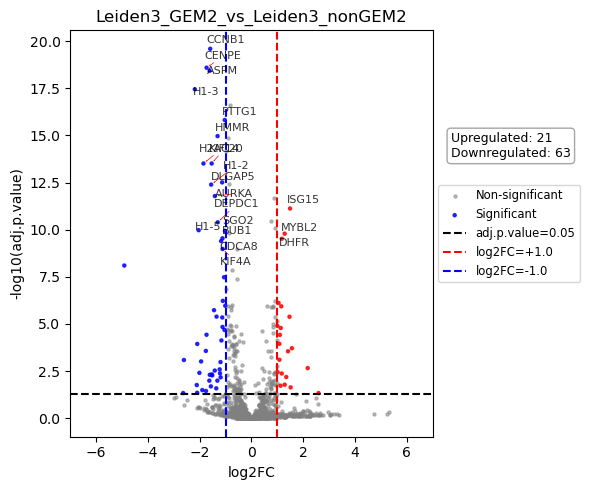

Volcano plot saved to /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures/volcano_Leiden3_GEM2_vs_Leiden3_nonGEM2.png


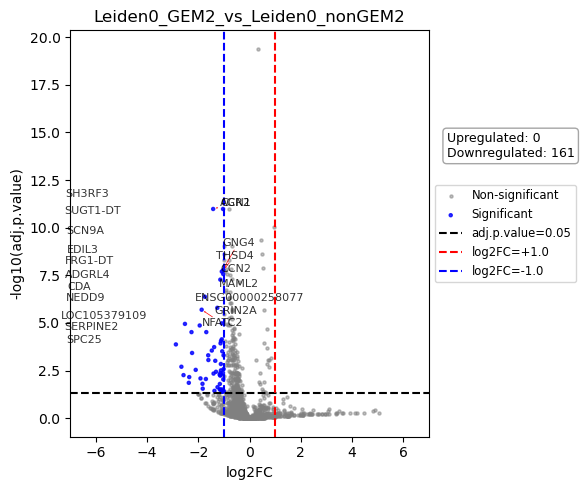

Volcano plot saved to /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures/volcano_Leiden0_GEM2_vs_Leiden0_nonGEM2.png


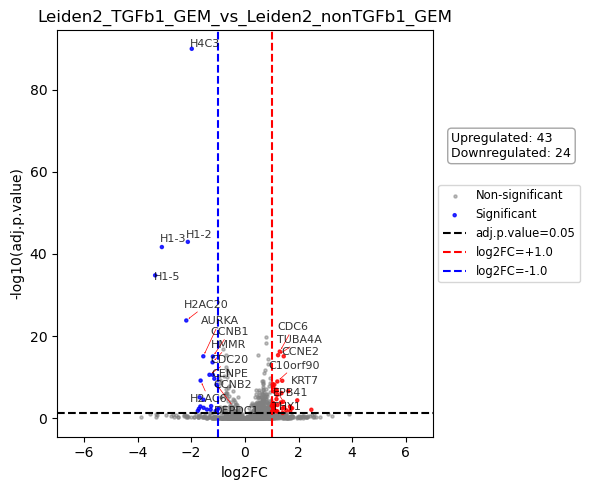

Volcano plot saved to /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures/volcano_Leiden2_TGFb1_GEM_vs_Leiden2_nonTGFb1_GEM.png


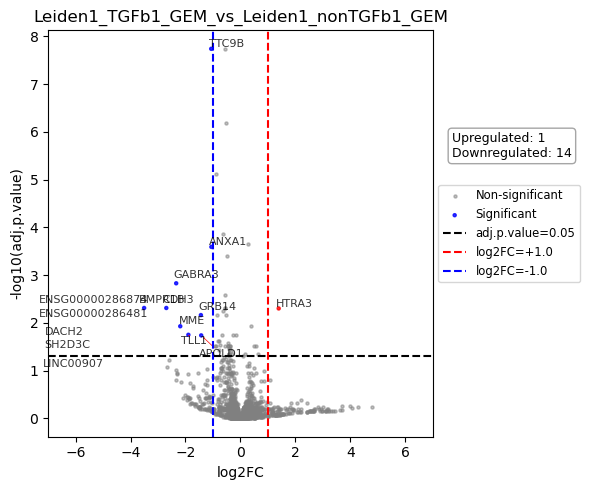

Volcano plot saved to /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures/volcano_Leiden1_TGFb1_GEM_vs_Leiden1_nonTGFb1_GEM.png


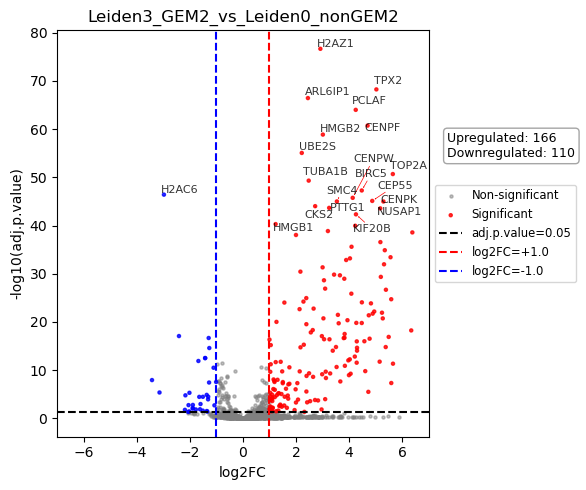

Volcano plot saved to /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures/volcano_Leiden3_GEM2_vs_Leiden0_nonGEM2.png


In [212]:
# Iterate over each comparison's DataFrame in results_dict
for comp_key, df in results_dict.items():
    # Skip if no results were returned (e.g., some comparisons might have failed)
    if df is None:
        print(f"No data for {comp_key}, skipping...")
        continue
    
    # Parse the key to extract group1 and group2 
    # e.g. "Leiden3_vs_Leiden0" -> group1="Leiden3", group2="Leiden0"
    if "_vs_" in comp_key:
        group1_str, group2_str = comp_key.split("_vs_")
    else:
        # Fallback if key doesn't follow the expected pattern
        group1_str, group2_str = "UnknownGroup1", "UnknownGroup2"
    
    # Call the volcano plotting function
    plot_volcano(
        df=df,
        group1=group1_str,
        group2=group2_str,
        log2fc_threshold=1.0,
        adj_pval_threshold=0.05,
        top_n=20
    )


### Barplot 

In [213]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

def plot_top_genes_bar(
    df,
    group1,
    group2,
    figure_dir=".",
    n_top_genes=20,
    color_by="basemean"
):
    """
    Plot a bar plot of the top N genes (by adjusted p-value) from a DE result DataFrame,
    using matplotlib only (no seaborn). The figure is displayed interactively and also saved.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Must have ['symbol', 'log2FC', 'adjusted.p.value'] columns.
        If `color_by` (e.g. 'basemean') also exists, it will color bars by that value.
    group1, group2 : str or list
        If lists, they will be joined by '_'. Used for labeling/saving.
    figure_dir : str
        Directory to save the figure.
    n_top_genes : int
        Number of top genes to plot (by ascending adjusted p-value).
    color_by : str
        Column name to determine bar coloring. If missing, a dummy column is used.
    """

    # Convert group1/group2 to strings
    g1 = "_".join(group1) if isinstance(group1, list) else str(group1)
    g2 = "_".join(group2) if isinstance(group2, list) else str(group2)
    comparison = f"{g1}_vs_{g2}"

    # Ensure output directory exists
    os.makedirs(figure_dir, exist_ok=True)

    # Copy and sort by ascending adjusted p-value
    filtered_results = df.copy()
    filtered_results.sort_values(by="adjusted.p.value", ascending=True, inplace=True)

    # Select top N
    top_by_pvalue = filtered_results.head(n_top_genes).copy()

    # Ensure log2FC is numeric
    top_by_pvalue['log2FC'] = pd.to_numeric(top_by_pvalue['log2FC'], errors='coerce')

    # If the column to color by is missing, create a dummy column
    if color_by not in top_by_pvalue.columns:
        top_by_pvalue[color_by] = 1.0

    # Make sure the color_by column is numeric
    top_by_pvalue[color_by] = pd.to_numeric(top_by_pvalue[color_by], errors='coerce').fillna(1.0)

    # Create a figure and an Axes
    fig, ax = plt.subplots(figsize=(5, 6))

    # Prepare a colormap normalized to [min(color_by), max(color_by)]
    cmap = mpl.cm.viridis
    color_min = top_by_pvalue[color_by].min()
    color_max = top_by_pvalue[color_by].max()
    norm = mpl.colors.Normalize(vmin=color_min, vmax=color_max)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # needed for colorbar

    # Map each bar's color
    bar_colors = [sm.to_rgba(val) for val in top_by_pvalue[color_by]]

    # Plot horizontal bars (better readability for gene labels)
    y_positions = np.arange(len(top_by_pvalue))
    ax.barh(
        y=y_positions,
        width=top_by_pvalue['log2FC'],
        color=bar_colors,
        edgecolor='black',
        height=0.6
    )

    # Configure the y-axis to show gene symbols
    ax.set_yticks(y_positions)
    ax.set_yticklabels(top_by_pvalue['symbol'])

    # Title and axis labels
    ax.set_title(f"Top {n_top_genes} genes in {comparison}")
    ax.set_xlabel("log2FC")
    ax.set_ylabel("Gene symbol")

    # Add colorbar
    cbar = fig.colorbar(sm, ax=ax)  # <-- specify 'ax=ax' or 'ax=[ax]' so it knows where to attach
    cbar.set_label(f"{color_by}", rotation=270, labelpad=15)

    # Optionally add a vertical line at x=0 for reference
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)

    # Tight layout
    plt.tight_layout()

    # Save the figure
    outpath = os.path.join(figure_dir, f"barplot_{comparison}.png")
    fig.savefig(outpath, dpi=150)
    print(f"Bar plot saved to {outpath}")

    # Display the figure on screen
    plt.show()


Bar plot saved to /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures/barplot_Leiden3_GEM2_vs_Leiden3_nonGEM2.png


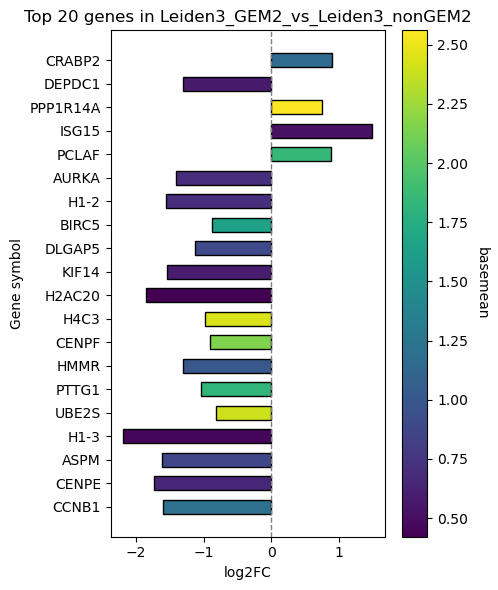

Bar plot saved to /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures/barplot_Leiden0_GEM2_vs_Leiden0_nonGEM2.png


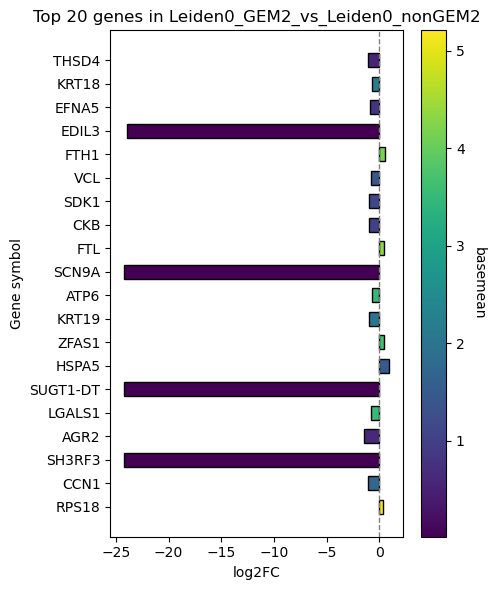

Bar plot saved to /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures/barplot_Leiden2_TGFb1_GEM_vs_Leiden2_nonTGFb1_GEM.png


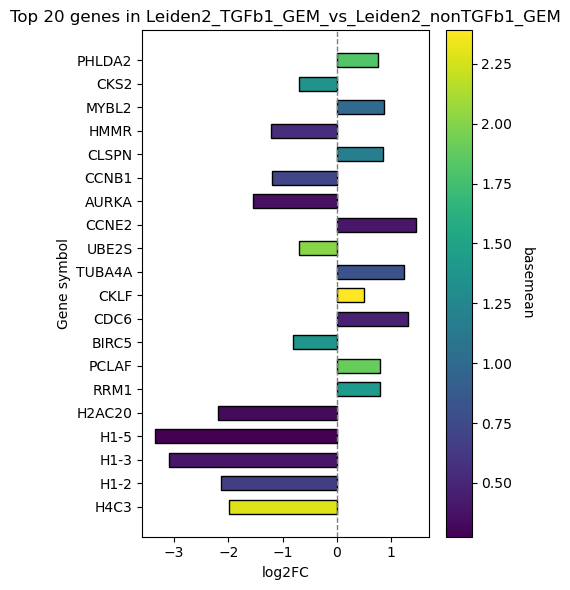

Bar plot saved to /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures/barplot_Leiden1_TGFb1_GEM_vs_Leiden1_nonTGFb1_GEM.png


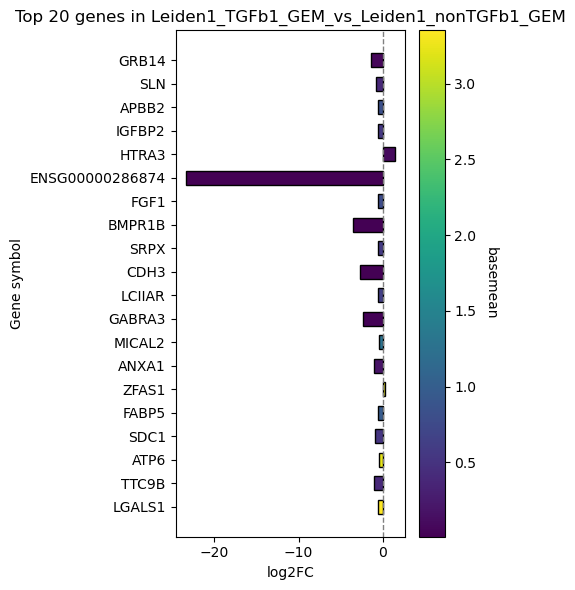

Bar plot saved to /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures/barplot_Leiden3_GEM2_vs_Leiden0_nonGEM2.png


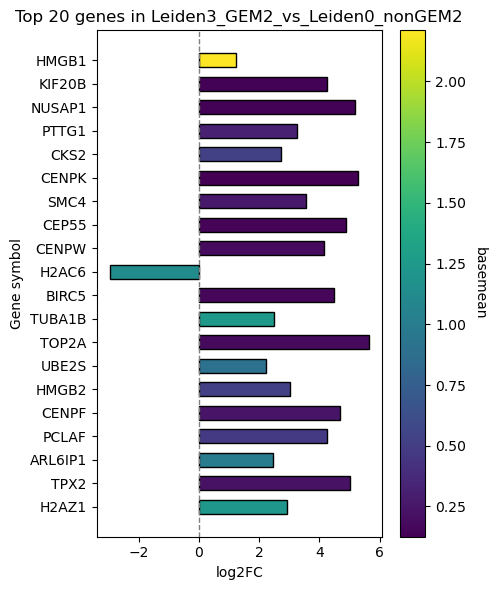

In [214]:
# Iterate over each comparison's DataFrame in results_dict
for comp_key, df in results_dict.items():
    # Skip if no results were returned (e.g., some comparisons might have failed)
    if df is None:
        print(f"No data for {comp_key}, skipping...")
        continue
    
    # Parse the key to extract group1 and group2 
    # e.g. "Leiden3_vs_Leiden0" -> group1="Leiden3", group2="Leiden0"
    if "_vs_" in comp_key:
        group1_str, group2_str = comp_key.split("_vs_")
    else:
        # Fallback if key doesn't follow the expected pattern
        group1_str, group2_str = "UnknownGroup1", "UnknownGroup2"
    
    # Call the bar plotting function
    # Adjust parameters (n_top_genes, color_by) as desired
    plot_top_genes_bar(
        df=df,
        group1=group1_str,
        group2=group2_str,
        figure_dir="/storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures",
        n_top_genes=20,
        color_by="basemean"  # could also be "log2FC" or any numeric column
    )


In [215]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

def plot_top_genes_bar_colored(
    df,
    group1,
    group2,
    figure_dir=".",
    n_top_genes=20
):
    """
    Create a bar plot of the top N genes (by ascending 'adjusted.p.value'), 
    with bar length = log2FC and bar color = basemean. A colorbar is included 
    to show the normalized 'basemean' range.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Should have at least ['symbol', 'log2FC', 'adjusted.p.value'].
        If 'basemean' is missing, you can either skip or set a dummy fallback.
    group1, group2 : str
        Labels for the two groups being compared.
    figure_dir : str
        Directory in which to save the output plot.
    n_top_genes : int
        Number of top genes (by ascending adjusted.p.value) to show.
    """

    # Ensure output directory exists
    os.makedirs(figure_dir, exist_ok=True)

    comparison = f"{group1}_vs_{group2}"

    # --------------------------------------------------
    # Handle potential missing 'basemean' column
    # --------------------------------------------------
    if 'basemean' not in df.columns:
        # --Approach A: Skip this plot--
        """
        print(f"No 'basemean' column found for {comparison}, skipping...")
        return
        """
        
        # --Approach B: Use a dummy fallback--
        print(f"No 'basemean' found for {comparison}, using dummy column = 1.0")
        df['basemean'] = 1.0

    # --------------------------------------------------
    # Select top N genes by adjusted p-value
    # --------------------------------------------------
    filtered_results = df.sort_values("adjusted.p.value").head(n_top_genes).copy()

    # Optionally sort these top genes by 'symbol' 
    filtered_results.sort_values(by="symbol", inplace=True)

    # Make sure log2FC and basemean are numeric
    filtered_results['log2FC'] = pd.to_numeric(filtered_results['log2FC'], errors='coerce')
    filtered_results['basemean'] = pd.to_numeric(filtered_results['basemean'], errors='coerce')

    # --------------------------------------------------
    # Create color normalization + colormap (for basemean)
    # --------------------------------------------------
    min_val = filtered_results['basemean'].min()
    max_val = filtered_results['basemean'].max()
    norm = plt.Normalize(min_val, max_val)

    # Create a blue-white-red diverging palette
    cmap = sns.diverging_palette(240, 10, s=80, l=55, as_cmap=True)

    # Convert each basemean value to an RGBA color
    basemean_colors = cmap(norm(filtered_results['basemean'].values))

    # --------------------------------------------------
    # Create the bar plot
    # --------------------------------------------------
    fig, ax = plt.subplots(figsize=(5, 5))

    # Use seaborn barplot with custom colors
    sns.barplot(
        data=filtered_results,
        x="log2FC",
        y="symbol",
        palette=basemean_colors,
        edgecolor=".2",
        ax=ax
    )

    ax.set_title(f"Top {n_top_genes} genes in {comparison}")
    ax.set_xlabel("log2FC")
    ax.set_ylabel("Gene symbol")

    # --------------------------------------------------
    # Colorbar
    # --------------------------------------------------
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # needed so colorbar knows its data range
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Normalized basemean", rotation=270, labelpad=15)

    plt.tight_layout()

    # --------------------------------------------------
    # Save + Display
    # --------------------------------------------------
    outpath = os.path.join(figure_dir, f"barplot_{comparison}.png")
    plt.savefig(outpath, dpi=150)
    plt.show()
    print(f"Bar plot saved to {outpath}")


# ==================================================================
# Example usage: iterate over comparisons in results_dict
# ==================================================================
# for comp_key, df in results_dict.items():
#     if df is None:
#         print(f"No data for {comp_key}, skipping...")
#         continue
#     
#     if "_vs_" in comp_key:
#         group1_str, group2_str = comp_key.split("_vs_")
#     else:
#         group1_str, group2_str = "UnknownGroup1", "UnknownGroup2"
#     
#     plot_top_genes_bar_colored(
#         df=df,
#         group1=group1_str,
#         group2=group2_str,
#         figure_dir="/storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures",
#         n_top_genes=20
#     )


/tmp/ipykernel_2149104/3190407058.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2149104/3190407058.py:83: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


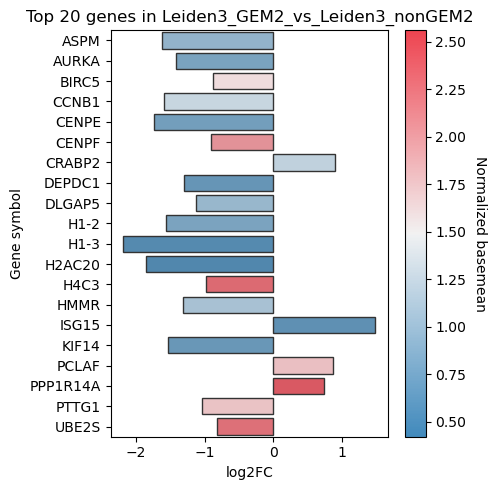

Bar plot saved to /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures/barplot_Leiden3_GEM2_vs_Leiden3_nonGEM2.png


/tmp/ipykernel_2149104/3190407058.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2149104/3190407058.py:83: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


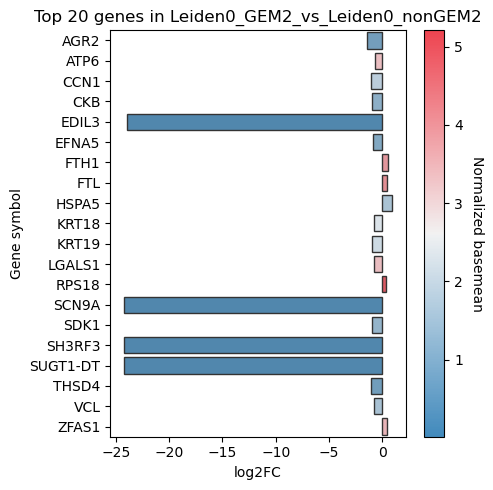

Bar plot saved to /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures/barplot_Leiden0_GEM2_vs_Leiden0_nonGEM2.png


/tmp/ipykernel_2149104/3190407058.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2149104/3190407058.py:83: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


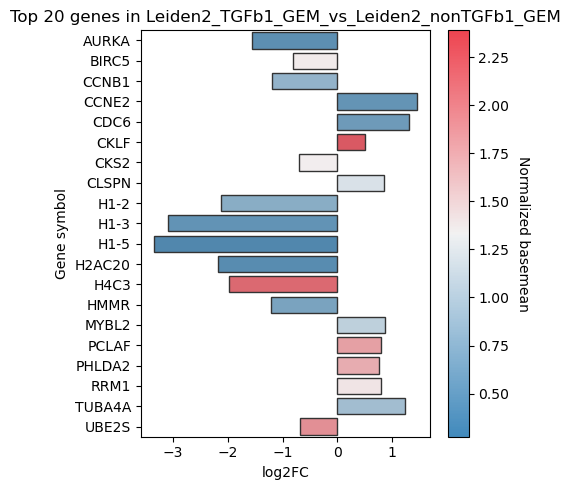

Bar plot saved to /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures/barplot_Leiden2_TGFb1_GEM_vs_Leiden2_nonTGFb1_GEM.png


/tmp/ipykernel_2149104/3190407058.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2149104/3190407058.py:83: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


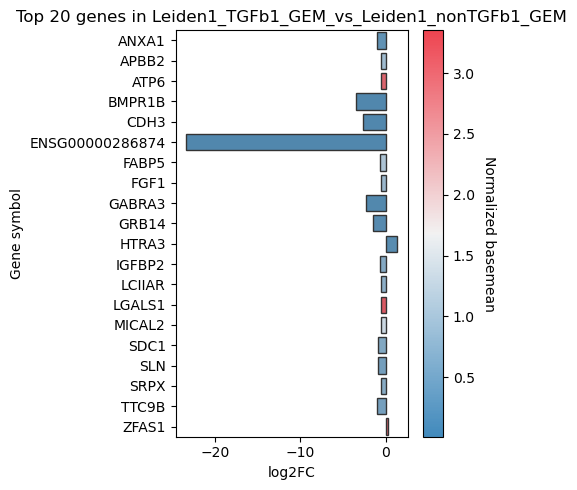

Bar plot saved to /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures/barplot_Leiden1_TGFb1_GEM_vs_Leiden1_nonTGFb1_GEM.png


/tmp/ipykernel_2149104/3190407058.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2149104/3190407058.py:83: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


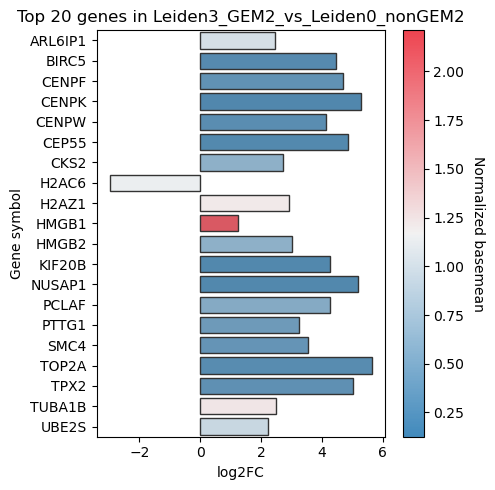

Bar plot saved to /storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures/barplot_Leiden3_GEM2_vs_Leiden0_nonGEM2.png


In [216]:
# ==================================================================
# Example usage: iterate over comparisons in results_dict
# ==================================================================
for comp_key, df in results_dict.items():
     if df is None:
         print(f"No data for {comp_key}, skipping...")
         continue
     
     if "_vs_" in comp_key:
         group1_str, group2_str = comp_key.split("_vs_")
     else:
         group1_str, group2_str = "UnknownGroup1", "UnknownGroup2"
     
     plot_top_genes_bar_colored(
         df=df,
         group1=group1_str,
         group2=group2_str,
         figure_dir="/storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum/figures",
         n_top_genes=20
     )

# Test why many genes have zero pvalue

### to test why some genes have zero pvalues I look at the expression values (counts) and calculate the mean count for each genes and each group that is compared int the differential expression

#### than I filter for different criteria, or the gene symbol/IDs with zero pvalue and standard deviation

In [47]:
import scanpy as sc
import pandas as pd
import numpy as np

# Assuming you have your AnnData object 'adata'
# Step 1: Calculate the mean and standard deviation for each gene in each cluster
unique_clusters = adata.obs['compare_clusters'].unique()

# Initialize DataFrames to store the mean, standard deviation, and cell counts
mean_expression = pd.DataFrame(index=adata.var_names)
std_expression = pd.DataFrame(index=adata.var_names)
cell_counts = {}

# Calculate the mean and standard deviation for each cluster
for cluster in unique_clusters:
    # Select cells belonging to the current cluster
    cluster_cells = adata[adata.obs['compare_clusters'] == cluster]
    
    # Convert sparse matrix to dense
    dense_matrix = cluster_cells.X.toarray()
    
    # Calculate the mean expression for the current cluster
    mean_expression[cluster] = dense_matrix.mean(axis=0)
    
    # Calculate the standard deviation for the current cluster
    std_expression[cluster] = dense_matrix.std(axis=0)
    
    # Store the number of cells in the current cluster
    cell_counts[cluster] = dense_matrix.shape[0]

# Step 2: Combine the mean and standard deviation into a single DataFrame
combined_expression = pd.concat([mean_expression, std_expression], axis=1, keys=['Mean', 'Std'])

# Step 3: Filter genes of interest
# List of gene symbols to filter
gene_symbols = [
    "ENSG00000131747",
    "ENSG00000170312",
    "ENSG00000117724",
    "ENSG00000088325",
    "ENSG00000148773",
    "ENSG00000164104",
    "ENSG00000137804",
    "ENSG00000011426",
    "ENSG00000089685",
    "ENSG00000166803",
    "ENSG00000198901"
]

# Filter the combined DataFrame using the gene symbols
filtered_combined_expression = combined_expression.loc[combined_expression.index.intersection(gene_symbols)]

# Add cell counts as columns
for cluster in unique_clusters:
    filtered_combined_expression[f'Cell_Count_{cluster}'] = cell_counts[cluster]

# Display the filtered_combined_expression DataFrame
print(filtered_combined_expression)


                     Mean                                        Std  \
                       NA 2non-reistant_all 1resistant_all        NA   
Gene                                                                   
ENSG00000117724  0.204950          0.722772       2.191979  0.497116   
ENSG00000164104  0.545135          0.657694       1.901719  0.630126   
ENSG00000011426  0.137162          0.378022       1.384623  0.408829   
ENSG00000170312  0.098040          0.194524       1.416363  0.374431   
ENSG00000148773  0.118287          0.424951       1.694866  0.441405   
ENSG00000137804  0.181509          0.399911       1.514858  0.553479   
ENSG00000166803  0.367936          0.831302       1.890110  0.667306   
ENSG00000198901  0.127313          0.551327       1.535379  0.357332   
ENSG00000131747  0.139679          0.476039       2.276853  0.433248   
ENSG00000089685  0.134783          0.586888       1.647341  0.401822   
ENSG00000088325  0.202183          0.753773       2.201183  0.53

In [48]:
filtered_combined_expression

Mean                                        Std  \
                       NA 2non-reistant_all 1resistant_all        NA   
Gene                                                                   
ENSG00000117724  0.204950          0.722772       2.191979  0.497116   
ENSG00000164104  0.545135          0.657694       1.901719  0.630126   
ENSG00000011426  0.137162          0.378022       1.384623  0.408829   
ENSG00000170312  0.098040          0.194524       1.416363  0.374431   
ENSG00000148773  0.118287          0.424951       1.694866  0.441405   
ENSG00000137804  0.181509          0.399911       1.514858  0.553479   
ENSG00000166803  0.367936          0.831302       1.890110  0.667306   
ENSG00000198901  0.127313          0.551327       1.535379  0.357332   
ENSG00000131747  0.139679          0.476039       2.276853  0.433248   
ENSG00000089685  0.134783          0.586888       1.647341  0.401822   
ENSG00000088325  0.202183          0.753773       2.201183  0.537121   

                                                 Cell_Count_NA  \
                2non-reistant_all 1resistant_all                 
Gene                                                             
ENSG00000117724          0.894937       0.708124          1224   
ENSG00000164104          0.774719       0.643709          1224   
ENSG00000011426          0.545262       0.639859          1224   
ENSG00000170312          0.427934       0.676896          1224   
ENSG00000148773          0.679844       0.686353          1224   
ENSG00000137804          0.601957       0.647629          1224   
ENSG00000166803          0.826415       0.607337          1224   
ENSG00000198901          0.723914       0.594951          1224   
ENSG00000131747          0.718862       0.856647          1224   
ENSG00000089685          0.774820       0.621574          1224   
ENSG00000088325          0.941930       0.658882          1224   

                Cell_Count_2non-reistant_all Cell_Count_1resistant_all  
                                                                        
Gene                                                                    
ENSG00000117724                         6299                      3071  
ENSG00000164104                         6299                      3071  
ENSG00000011426                         6299                      3071  
ENSG00000170312                         6299                      3071  
ENSG00000148773                         6299                      3071  
ENSG00000137804                         6299                      3071  
ENSG00000166803                         6299                      3071  
ENSG00000198901                         6299                      3071  
ENSG00000131747                         6299                      3071  
ENSG00000089685                         6299                      3071  
ENSG00000088325                         6299                      3071

### Caclulate a t test in the average count per group and the Std (just to make easy stats)


In [49]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_ind_from_stats


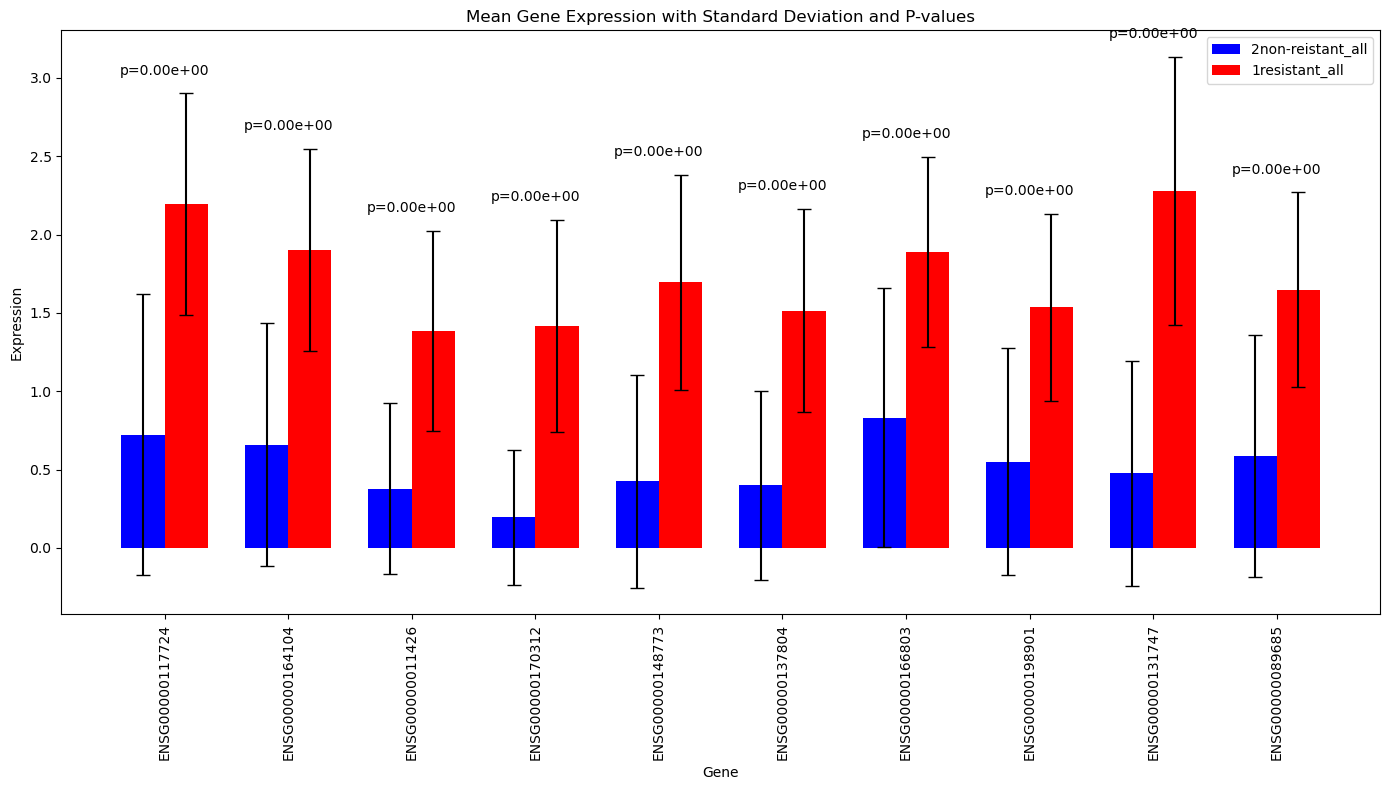

In [58]:
# Extract the first ten rows (already have 11 here)
filtered_combined_expression = filtered_combined_expression.head(10)

# Convert to dictionary format
data = {
    'Gene': filtered_combined_expression.index.tolist(),
    'Mean_2non_reistant_all': filtered_combined_expression[('Mean', '2non-reistant_all')].tolist(),
    'Mean_1resistant_all': filtered_combined_expression[('Mean', '1resistant_all')].tolist(),
    'Std_2non_reistant_all': filtered_combined_expression[('Std', '2non-reistant_all')].tolist(),
    'Std_1resistant_all': filtered_combined_expression[('Std', '1resistant_all')].tolist()
}



df = pd.DataFrame(data)
df.set_index('Gene', inplace=True)

# Perform t-tests
results = []
for gene in df.index:
    mean1 = df.loc[gene, 'Mean_2non_reistant_all']
    std1 = df.loc[gene, 'Std_2non_reistant_all']
    mean2 = df.loc[gene, 'Mean_1resistant_all']
    std2 = df.loc[gene, 'Std_1resistant_all']
    
    # Assume equal sample sizes for simplicity, adjust if necessary
    n1 = n2 = 10000  # Example sample sizes
    
    # Calculate t-test
    t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False)
    results.append((gene, t_stat, p_value))

# Create a DataFrame with the t-test results
ttest_results_df = pd.DataFrame(results, columns=['Gene', 'T-statistic', 'P-value'])
ttest_results_df.set_index('Gene', inplace=True)

# Plot the mean values with standard deviations and annotate with p-values
plt.figure(figsize=(14, 8))

bar_width = 0.35
genes = df.index
index = range(len(genes))

# Bar plots for the two conditions
bar1 = plt.bar(index, df['Mean_2non_reistant_all'], bar_width, yerr=df['Std_2non_reistant_all'], label='2non-reistant_all', capsize=5, color='blue')
bar2 = plt.bar([i + bar_width for i in index], df['Mean_1resistant_all'], bar_width, yerr=df['Std_1resistant_all'], label='1resistant_all', capsize=5, color='red')

# Annotate p-values
for i, gene in enumerate(genes):
    p_value = ttest_results_df.loc[gene, 'P-value']
    plt.text(i + bar_width / 2, max(df.loc[gene, 'Mean_2non_reistant_all'] + df.loc[gene, 'Std_2non_reistant_all'], df.loc[gene, 'Mean_1resistant_all'] + df.loc[gene, 'Std_1resistant_all']) + 0.1, f'p={p_value:.2e}', ha='center', va='bottom')

plt.xlabel('Gene')
plt.ylabel('Expression')
plt.title('Mean Gene Expression with Standard Deviation and P-values')
plt.xticks([i + bar_width / 2 for i in index], genes, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


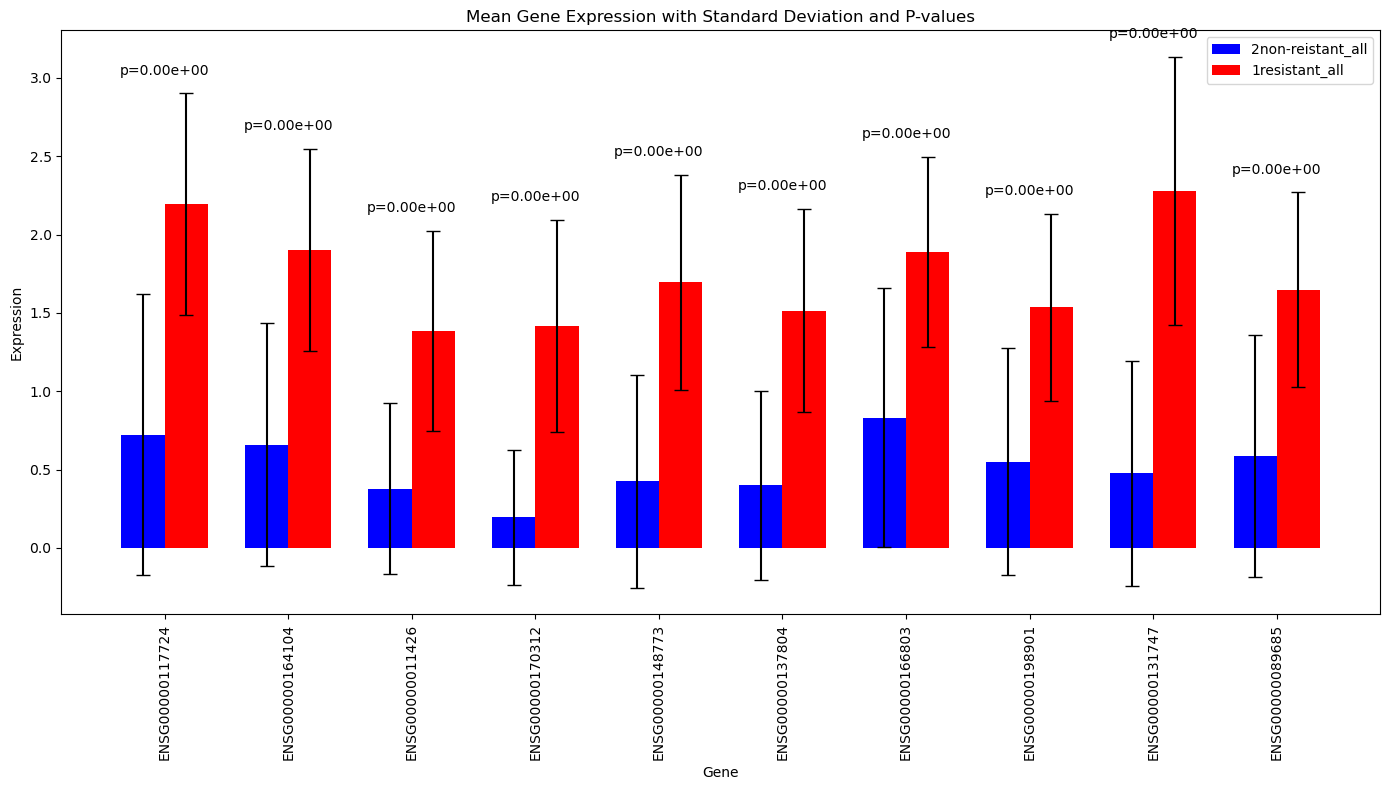

In [51]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind_from_stats

# Assuming you have your AnnData object 'adata'
# Step 1: Calculate the mean and standard deviation for each gene in each cluster
unique_clusters = adata.obs['compare_clusters'].unique()

# Initialize DataFrames to store the mean, standard deviation, and cell counts
mean_expression = pd.DataFrame(index=adata.var_names)
std_expression = pd.DataFrame(index=adata.var_names)
cell_counts = {}

# Calculate the mean and standard deviation for each cluster
for cluster in unique_clusters:
    # Select cells belonging to the current cluster
    cluster_cells = adata[adata.obs['compare_clusters'] == cluster]
    
    # Convert sparse matrix to dense
    dense_matrix = cluster_cells.X.toarray()
    
    # Calculate the mean expression for the current cluster
    mean_expression[cluster] = dense_matrix.mean(axis=0)
    
    # Calculate the standard deviation for the current cluster
    std_expression[cluster] = dense_matrix.std(axis=0)
    
    # Store the number of cells in the current cluster
    cell_counts[cluster] = dense_matrix.shape[0]

# Step 2: Combine the mean and standard deviation into a single DataFrame
combined_expression = pd.concat([mean_expression, std_expression], axis=1, keys=['Mean', 'Std'])

# Step 3: Filter genes of interest
# List of gene symbols to filter
gene_symbols = [
    "ENSG00000131747",
    "ENSG00000170312",
    "ENSG00000117724",
    "ENSG00000088325",
    "ENSG00000148773",
    "ENSG00000164104",
    "ENSG00000137804",
    "ENSG00000011426",
    "ENSG00000089685",
    "ENSG00000166803",
    "ENSG00000198901"
]

# Filter the combined DataFrame using the gene symbols
filtered_combined_expression = combined_expression.loc[combined_expression.index.intersection(gene_symbols)]

# Add cell counts as columns
for cluster in unique_clusters:
    filtered_combined_expression[f'Cell_Count_{cluster}'] = cell_counts[cluster]

# Extract the first ten rows (already have 11 here)
filtered_combined_expression = filtered_combined_expression.head(10)

# Convert to dictionary format
data = {
    'Gene': filtered_combined_expression.index.tolist(),
    'Mean_2non_reistant_all': filtered_combined_expression[('Mean', '2non-reistant_all')].tolist(),
    'Mean_1resistant_all': filtered_combined_expression[('Mean', '1resistant_all')].tolist(),
    'Std_2non_reistant_all': filtered_combined_expression[('Std', '2non-reistant_all')].tolist(),
    'Std_1resistant_all': filtered_combined_expression[('Std', '1resistant_all')].tolist(),
    'Cell_Count_2non_reistant_all': filtered_combined_expression['Cell_Count_2non-reistant_all'].tolist(),
    'Cell_Count_1resistant_all': filtered_combined_expression['Cell_Count_1resistant_all'].tolist()
}

# Convert the dictionary back to a DataFrame
df = pd.DataFrame(data)
df.set_index('Gene', inplace=True)

# Perform t-tests
results = []
for gene in df.index:
    mean1 = df.loc[gene, 'Mean_2non_reistant_all']
    std1 = df.loc[gene, 'Std_2non_reistant_all']
    mean2 = df.loc[gene, 'Mean_1resistant_all']
    std2 = df.loc[gene, 'Std_1resistant_all']
    n1 = df.loc[gene, 'Cell_Count_2non_reistant_all']
    n2 = df.loc[gene, 'Cell_Count_1resistant_all']
    
    # Calculate t-test
    t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False)
    results.append((gene, t_stat, p_value))

# Create a DataFrame with the t-test results
ttest_results_df = pd.DataFrame(results, columns=['Gene', 'T-statistic', 'P-value'])
ttest_results_df.set_index('Gene', inplace=True)

# Plot the mean values with standard deviations and annotate with p-values
plt.figure(figsize=(14, 8))

bar_width = 0.35
genes = df.index
index = range(len(genes))

# Bar plots for the two conditions
bar1 = plt.bar(index, df['Mean_2non_reistant_all'], bar_width, yerr=df['Std_2non_reistant_all'], label='2non-reistant_all', capsize=5, color='blue')
bar2 = plt.bar([i + bar_width for i in index], df['Mean_1resistant_all'], bar_width, yerr=df['Std_1resistant_all'], label='1resistant_all', capsize=5, color='red')

# Annotate p-values
for i, gene in enumerate(genes):
    p_value = ttest_results_df.loc[gene, 'P-value']
    plt.text(i + bar_width / 2, max(df.loc[gene, 'Mean_2non_reistant_all'] + df.loc[gene, 'Std_2non_reistant_all'], df.loc[gene, 'Mean_1resistant_all'] + df.loc[gene, 'Std_1resistant_all']) + 0.1, f'p={p_value:.2e}', ha='center', va='bottom')

plt.xlabel('Gene')
plt.ylabel('Expression')
plt.title('Mean Gene Expression with Standard Deviation and P-values')
plt.xticks([i + bar_width / 2 for i in index], genes, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


The phenomenon where the p-value tends to decrease as the sample size increases is well-known in statistical hypothesis testing. This is because the test statistics (such as the t-statistic) become more sensitive to smaller effects as the sample size grows.

The formula for the t-statistic in a two-sample t-test is:

𝑡
=
𝑋
ˉ
1
−
𝑋
ˉ
2
𝑆
1
2
𝑛
1
+
𝑆
2
2
𝑛
2
t= 
n 
1
​
 
S 
1
2
​
 
​
 + 
n 
2
​
 
S 
2
2
​
 
​
 
​
 
X
ˉ
  
1
​
 − 
X
ˉ
  
2
​
 
​
 

Where:

𝑋
ˉ
1
X
ˉ
  
1
​
  and 
𝑋
ˉ
2
X
ˉ
  
2
​
  are the sample means
𝑆
1
2
S 
1
2
​
  and 
𝑆
2
2
S 
2
2
​
  are the sample variances
𝑛
1
n 
1
​
  and 
𝑛
2
n 
2
​
  are the sample sizes
As the sample sizes 
𝑛
1
n 
1
​
  and 
𝑛
2
n 
2
​
  increase, the denominator (standard error) decreases, making the t-statistic larger (assuming the difference between means 
𝑋
ˉ
1
−
𝑋
ˉ
2
X
ˉ
  
1
​
 − 
X
ˉ
  
2
​
  stays the same). A larger t-statistic typically leads to a smaller p-value.

This behavior means that with large enough sample sizes, even very small differences between groups can become statistically significant. This doesn't necessarily mean these differences are practically significant, which is why it's important to consider effect size and confidence intervals along with p-values.

Addressing the Issue
To address this issue, several approaches can be used:

Effect Size: Report effect sizes (such as Cohen's d) alongside p-values to give a sense of the magnitude of the observed effect.
Confidence Intervals: Report confidence intervals to provide a range within which the true effect size is likely to fall.
P-value Correction: Use p-value corrections such as the Bonferroni correction when multiple comparisons are made, though this doesn't directly address the sample size issue.
Bayesian Methods: Consider Bayesian methods, which incorporate prior information and can be less sensitive to large sample sizes.
Practical Significance: Emphasize practical or clinical significance over statistical significance.
Here’s how you can calculate and report effect sizes and confidence intervals in your analysis:

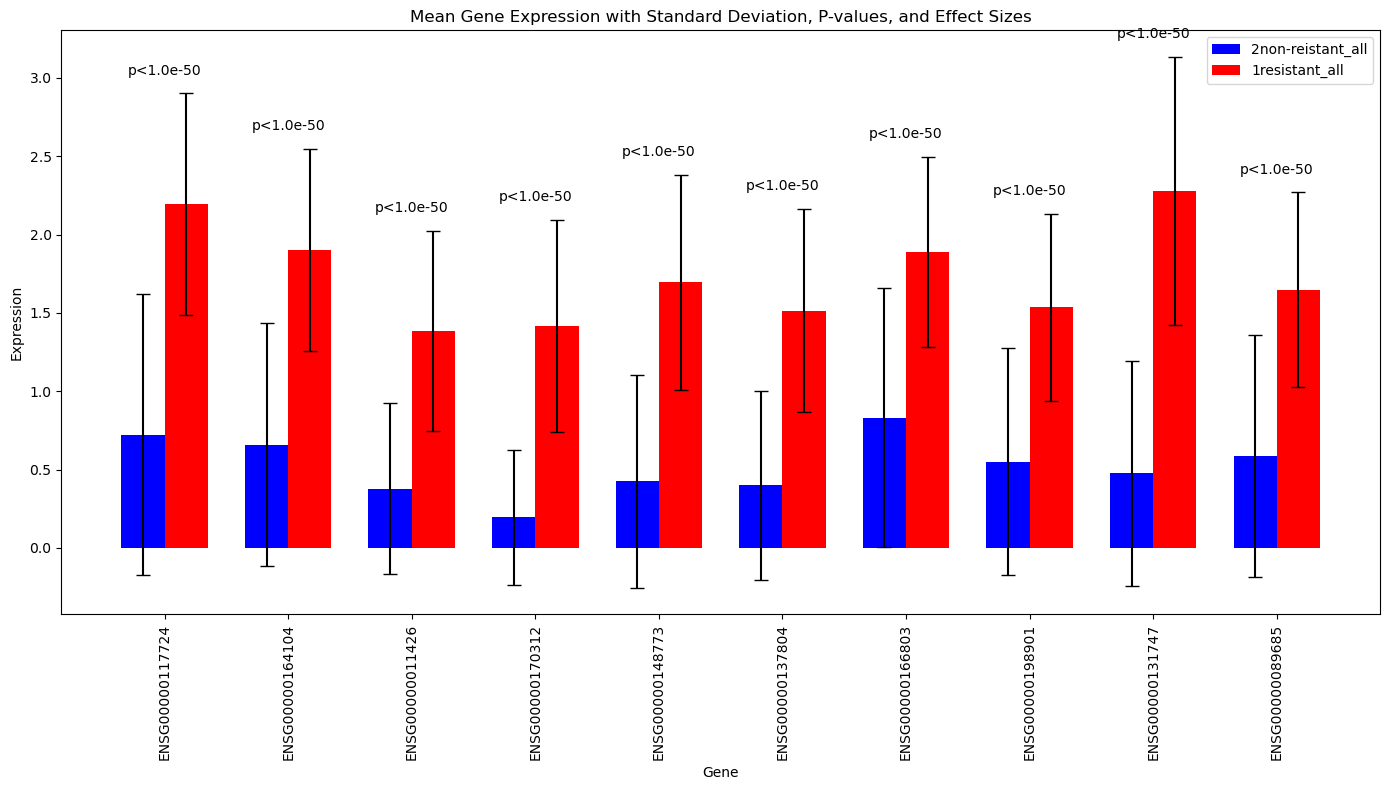

In [59]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind_from_stats
from scipy.stats import t as t_dist

# Assuming you have your AnnData object 'adata'
# Step 1: Calculate the mean and standard deviation for each gene in each cluster
unique_clusters = adata.obs['compare_clusters'].unique()

# Initialize DataFrames to store the mean, standard deviation, and cell counts
mean_expression = pd.DataFrame(index=adata.var_names)
std_expression = pd.DataFrame(index=adata.var_names)
cell_counts = {}

# Calculate the mean and standard deviation for each cluster
for cluster in unique_clusters:
    # Select cells belonging to the current cluster
    cluster_cells = adata[adata.obs['compare_clusters'] == cluster]
    
    # Convert sparse matrix to dense
    dense_matrix = cluster_cells.X.toarray()
    
    # Calculate the mean expression for the current cluster
    mean_expression[cluster] = dense_matrix.mean(axis=0)
    
    # Calculate the standard deviation for the current cluster
    std_expression[cluster] = dense_matrix.std(axis=0)
    
    # Store the number of cells in the current cluster
    cell_counts[cluster] = dense_matrix.shape[0]

# Step 2: Combine the mean and standard deviation into a single DataFrame
combined_expression = pd.concat([mean_expression, std_expression], axis=1, keys=['Mean', 'Std'])

# Step 3: Filter genes of interest
# List of gene symbols to filter
gene_symbols = [
    "ENSG00000131747",
    "ENSG00000170312",
    "ENSG00000117724",
    "ENSG00000088325",
    "ENSG00000148773",
    "ENSG00000164104",
    "ENSG00000137804",
    "ENSG00000011426",
    "ENSG00000089685",
    "ENSG00000166803",
    "ENSG00000198901"
]

# Filter the combined DataFrame using the gene symbols
filtered_combined_expression = combined_expression.loc[combined_expression.index.intersection(gene_symbols)]

# Add cell counts as columns
for cluster in unique_clusters:
    filtered_combined_expression[f'Cell_Count_{cluster}'] = cell_counts[cluster]

# Extract the first ten rows (already have 11 here)
filtered_combined_expression = filtered_combined_expression.head(10)

# Convert to dictionary format
data = {
    'Gene': filtered_combined_expression.index.tolist(),
    'Mean_2non_reistant_all': filtered_combined_expression[('Mean', '2non-reistant_all')].tolist(),
    'Mean_1resistant_all': filtered_combined_expression[('Mean', '1resistant_all')].tolist(),
    'Std_2non_reistant_all': filtered_combined_expression[('Std', '2non-reistant_all')].tolist(),
    'Std_1resistant_all': filtered_combined_expression[('Std', '1resistant_all')].tolist(),
    'Cell_Count_2non_reistant_all': filtered_combined_expression['Cell_Count_2non-reistant_all'].tolist(),
    'Cell_Count_1resistant_all': filtered_combined_expression['Cell_Count_1resistant_all'].tolist()
}

# Convert the dictionary back to a DataFrame
df = pd.DataFrame(data)
df.set_index('Gene', inplace=True)

# Perform t-tests and calculate effect sizes
results = []
for gene in df.index:
    mean1 = df.loc[gene, 'Mean_2non_reistant_all']
    std1 = df.loc[gene, 'Std_2non_reistant_all']
    mean2 = df.loc[gene, 'Mean_1resistant_all']
    std2 = df.loc[gene, 'Std_1resistant_all']
    n1 = df.loc[gene, 'Cell_Count_2non_reistant_all']
    n2 = df.loc[gene, 'Cell_Count_1resistant_all']
    
    # Calculate t-test
    t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False)
    
    # Calculate effect size (Cohen's d)
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    cohen_d = (mean1 - mean2) / pooled_std
    
    # Calculate confidence interval for the mean difference
    se_diff = np.sqrt(std1**2/n1 + std2**2/n2)
    mean_diff = mean1 - mean2
    df_diff = n1 + n2 - 2
    confidence_interval = t_dist.interval(0.95, df_diff, loc=mean_diff, scale=se_diff)
    
    results.append((gene, t_stat, p_value, cohen_d, confidence_interval))

# Create a DataFrame with the t-test results
ttest_results_df = pd.DataFrame(results, columns=['Gene', 'T-statistic', 'P-value', 'Cohen\'s d', '95% CI'])
ttest_results_df.set_index('Gene', inplace=True)

# Define a threshold for displaying p-values in scientific notation
p_value_threshold = 1e-50

# Plot the mean values with standard deviations and annotate with p-values
plt.figure(figsize=(14, 8))

bar_width = 0.35
genes = df.index
index = range(len(genes))

# Bar plots for the two conditions
bar1 = plt.bar(index, df['Mean_2non_reistant_all'], bar_width, yerr=df['Std_2non_reistant_all'], label='2non-reistant_all', capsize=5, color='blue')
bar2 = plt.bar([i + bar_width for i in index], df['Mean_1resistant_all'], bar_width, yerr=df['Std_1resistant_all'], label='1resistant_all', capsize=5, color='red')

# Annotate p-values
for i, gene in enumerate(genes):
    p_value = ttest_results_df.loc[gene, 'P-value']
    if p_value < p_value_threshold:
        p_value_str = f'p<{p_value_threshold:.1e}'
    else:
        p_value_str = f'p={p_value:.2e}'
    plt.text(i + bar_width / 2, max(df.loc[gene, 'Mean_2non_reistant_all'] + df.loc[gene, 'Std_2non_reistant_all'], df.loc[gene, 'Mean_1resistant_all'] + df.loc[gene, 'Std_1resistant_all']) + 0.1, p_value_str, ha='center', va='bottom')

plt.xlabel('Gene')
plt.ylabel('Expression')
plt.title('Mean Gene Expression with Standard Deviation, P-values, and Effect Sizes')
plt.xticks([i + bar_width / 2 for i in index], genes, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()
